<img style="float: center;" src='https://github.com/STScI-MIRI/MRS-ExampleNB/raw/main/assets/banner1.png' alt="stsci_logo" width="900px"/> 

<a id="title_ID"></a>
# MIRI MRS Batch Processing Notebook #

**Author**: David Law, AURA Associate Astronomer, MIRI branch
<br>
**Last Updated**: November 20, 2023
<br>
**Pipeline Version**: 1.12.5

The purpose of this notebook is to provide a framework for processing generic MIRI MRS data through all three pipeline stages.  Data is assumed to be located in two Observation folders (science and background) according to paths set up below.  It should not be necessary to edit any cells other than in the 'Configuration' section unless modifying the standard pipeline processing.

This example is set up to use observations of the LMC planetary nebula SMP LMC 058 obtained by PID 1523 Observation 3.  This is a point source that uses a standard 4-pt dither in all three grating settings.  It incorporates a dedicated background in Observation 4.  Input data for this notebook can be obtained by downloading the 'uncal' files from MAST and placing them in directories set up below.  

Changes:<br>
Sep 1 2022: Add some commentary and example on how to use multicore processing in Detector 1<br>
Sep 12 2022: Disable unnecessary cube/1d spectra production for individual science exposures in Spec 2<br>
Oct 14 2022: Include residual fringe correction in spec2 (note that this will CRASH earlier pipeline versions!<br>
Jun 29 2023: Update to latest 1.11.0 pipeline with photom, outlier detection, and x1d changes, add CRDS path options.  Change to SMP LMC 058 demo.<br>
Oct 11 2023: Update to 1.12.3 pipeline with 1d spectral residual fringe and auto-centroid options, 2d pixel replacement, and a variety of new cube build options.<br>
Nov 17 2023: Incorporate CRDS default parameters for detector1 and spec2<br>
Nov 20 2023: Significant revisions to allow use of associations in spec2, allow choice of pixel-based background subtraction.

<hr style="border:1px solid gray"> </hr>

1.<font color='white'>-</font>Configuration <a class="anchor" id="intro"></a>
------------------

In [1]:
# Set parameters to be changed here.
# It should not be necessary to edit cells below this in general unless modifying pipeline processing steps.

import sys,os, pdb

# CRDS context (if overriding)
#%env CRDS_CONTEXT jwst_1093.pmap

# Set CRDS paths if not set already in your .bashrc shell configuration
#os.environ['CRDS_PATH']='/Users/dlaw/crds_cache'
#os.environ['CRDS_SERVER_URL']='https://jwst-crds.stsci.edu'
# Echo CRDS path in use
print('CRDS local filepath:',os.environ['CRDS_PATH'])
print('CRDS file server:',os.environ['CRDS_SERVER_URL'])

# Point to where the uncalibrated FITS files are from the science observation
input_dir = '/Users/dlaw/FlightData/APT1523/data/Obs03/uncal/'

# Point to where you want the output science results to go
output_dir = '/Users/dlaw/FlightData/APT1523/data/Obs03'

# Point to where the uncalibrated FITS files are from the background observation
# If no background observation, leave this blank
input_bgdir = '/Users/dlaw/FlightData/APT1523/data/Obs04/uncal/'

# Point to where the output background observations should go
# If no background observation, leave this blank
output_bgdir = '/Users/dlaw/FlightData/APT1523/data/Obs04'

# Whether or not to process only data from a given band/channel
# Useful if overriding reference files
# Note BOTH must be set in order to work
use_ch='' # '12' or '34'
use_band='' # 'SHORT', 'MEDIUM', or 'LONG'

# Whether or not to run a given pipeline stage:

# Science processing
dodet1=True
dospec2=True
dospec3=True

# Background processing
dodet1bg=True
dospec2bg=True

# Where should background subtraction using the dedicated backgrounds be done?
# (Note that if using master-background subtraction, backgrounds must be select above to process through spec2)
pixel_bg = False # Pixel-based background subtraction in spec2 (direct pixel subtraction)
master_bg = True # Master-background subtraction in spec3 (subtract spectrum generated from the backgrounds)

# (If none of the above is done, cubes will not be background subtracted.  1d spectra will use local annular background subtraction for point sources)

# If there is no background folder, ensure we don't try to process it
if (input_bgdir == ''):
    dodet1bg=False
    dospec2bg=False

CRDS local filepath: /Users/dlaw/crds_cache/jwst_ops
CRDS file server: https://jwst-crds.stsci.edu


<hr style="border:1px solid gray"> </hr>

2.<font color='white'>-</font>Imports and setup <a class="anchor" id="intro"></a>
------------------

In [2]:
# Now let's use the entire available screen width for the notebook
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [3]:
# Basic system utilities for interacting with files
import glob
import time
import shutil
import warnings
import zipfile
import urllib.request

# Astropy utilities for opening FITS and ASCII files
from astropy.io import fits
from astropy.io import ascii
from astropy.utils.data import download_file
# Astropy utilities for making plots
from astropy.visualization import (LinearStretch, LogStretch, ImageNormalize, ZScaleInterval)

# Numpy for doing calculations
import numpy as np

# Matplotlib for making plots
import matplotlib.pyplot as plt
from matplotlib import rc

In [4]:
# Import the base JWST package
import jwst

In [5]:
# JWST pipelines (encompassing many steps)
from jwst.pipeline import Detector1Pipeline
from jwst.pipeline import Spec2Pipeline
from jwst.pipeline import Spec3Pipeline

# JWST pipeline utilities
from jwst import datamodels # JWST datamodels
from jwst.associations import asn_from_list as afl # Tools for creating association files
from jwst.associations.lib.rules_level2_base import DMSLevel2bBase # Definition of a Lvl2 association file
from jwst.associations.lib.rules_level3_base import DMS_Level3_Base # Definition of a Lvl3 association file

from stcal import dqflags # Utilities for working with the data quality (DQ) arrays

In [6]:
# Output subdirectories to keep science data products organized
# Note that the pipeline might complain about this as it is intended to work with everything in a single
# directory, but it nonetheless works fine for the examples given here.
det1_dir = os.path.join(output_dir, 'stage1/') # Detector1 pipeline outputs will go here
spec2_dir = os.path.join(output_dir, 'stage2/') # Spec2 pipeline outputs will go here
spec3_dir = os.path.join(output_dir, 'stage3/') # Spec3 pipeline outputs will go here

# We need to check that the desired output directories exist, and if not create them
if not os.path.exists(det1_dir):
    os.makedirs(det1_dir)
if not os.path.exists(spec2_dir):
    os.makedirs(spec2_dir)
if not os.path.exists(spec3_dir):
    os.makedirs(spec3_dir)

In [7]:
# Output subdirectories to keep background data products organized
det1_bgdir = os.path.join(output_bgdir, 'stage1/') # Detector1 pipeline outputs will go here
spec2_bgdir = os.path.join(output_bgdir, 'stage2/') # Spec2 pipeline outputs will go here

# We need to check that the desired output directories exist, and if not create them
if (output_bgdir != ''):
    if not os.path.exists(det1_bgdir):
        os.makedirs(det1_bgdir)
    if not os.path.exists(spec2_bgdir):
        os.makedirs(spec2_bgdir)

In [8]:
# Start a timer to keep track of runtime
time0 = time.perf_counter()

<hr style="border:1px solid gray"> </hr>

3.<font color='white'>-</font>Detector1 Pipeline <a class="anchor" id="det1"></a>
------------------

<div class="alert alert-block alert-warning">
In this section we process our data through the Detector1 pipeline to create Lvl2a data products (i.e., uncalibrated slope images).
See https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_detector1.html
</div>

In [9]:
# First we'll define a function that will call the detector1 pipeline with our desired set of parameters
# We won't enumerate the individual steps
def rundet1(filename, outdir):
    print(filename)
    # Set default configuration from CRDS param reference files
    crds_config = Detector1Pipeline.get_config_from_reference(filename)
    det1 = Detector1Pipeline.from_config_section(crds_config)
    
    det1.output_dir = outdir # Specify where the output should go
    
    # Overrides for whether or not certain steps should be skipped
    #det1.dq_init.skip = False
    #det1.saturation.skip = False
    #det1.firstframe.skip = False
    #det1.lastframe.skip = False
    #det1.reset.skip = False
    #det1.linearity.skip = False
    #det1.rscd.skip = False
    #det1.dark_current.skip = False
    #det1.refpix.skip = False
    #det1.jump.skip = False
    #det1.ramp_fit.skip = False
    #det1.gain_scale.skip = False
    
    # The jump and ramp fitting steps can benefit from multi-core processing, but this is off by default
    # Turn them on here if desired by choosing how many cores to use (quarter, half, or all)
    det1.jump.maximum_cores='half'
    det1.ramp_fit.maximum_cores='half'
    # This next parameter helps with very bright objects and/or very short ramps
    det1.jump.three_group_rejection_threshold=100
    
    # Enable detection of large cosmic ray showers (currently only works for FASTR1 data)
    det1.jump.find_showers=True
    
    # Bad pixel mask overrides
    #det1.dq_init.override_mask = 'myfile.fits'

    # Saturation overrides
    #et1.saturation.override_saturation = 'myfile.fits'
    
    # Reset overrides
    #det1.reset.override_reset = 'myfile.fits'
        
    # Linearity overrides
    #det1.linearity.override_linearity = 'myfile.fits'

    # RSCD overrides
    #det1.rscd.override_rscd = 'myfile.fits'
        
    # DARK overrides
    #det1.dark_current.override_dark = 'myfile.fits'
        
    # GAIN overrides
    #det1.jump.override_gain = 'myfile.fits'
    #det1.ramp_fit.override_gain = 'myfile.fits'
                
    # READNOISE overrides
    #det1.jump.override_readnoise = 'myfile.fits'
    #det1.ramp_fit.override_readnoise = 'myfile.fits'
        
    det1.save_results = True # Save the final resulting _rate.fits files
    det1(filename) # Run the pipeline on an input list of files

In [10]:
# Now let's look for input files of the form *uncal.fits from the science observation
sstring = input_dir + 'jw*mirifu*uncal.fits'
lvl1b_files = np.array(sorted(glob.glob(sstring)))

# If desired, check that these are the band/channel to use
if ((use_ch != '')&(use_band != '')):
    keep=np.zeros(len(lvl1b_files))
    for ii in range(0,len(lvl1b_files)):
        hdu=fits.open(lvl1b_files[ii])
        hdr=hdu[0].header
        if ((hdr['CHANNEL'] == use_ch)&(hdr['BAND'] == use_band)):
            keep[ii]=1
        hdu.close()
    indx=np.where(keep == 1)
    lvl1b_files=lvl1b_files[indx]

print('Found ' + str(len(lvl1b_files)) + ' science input files')

Found 24 science input files


In [11]:
# Run the pipeline on these input files by a simple loop over our pipeline function
if dodet1:
    for file in lvl1b_files:
        rundet1(file, det1_dir)
else:
    print('Skipping Detector1 processing for SCI data')

/Users/dlaw/FlightData/APT1523/data/Obs03/uncal/jw01523003001_03102_00001_mirifulong_uncal.fits


2023-11-20 12:54:11,443 - CRDS - ERROR -  Error determining best reference for 'pars-chargemigrationstep'  =   Unknown reference type 'pars-chargemigrationstep'
2023-11-20 12:54:11,449 - CRDS - ERROR -  Error determining best reference for 'pars-jumpstep'  =    parameter='META.INSTRUMENT.DETECTOR [DETECTOR]' value='MIRIFULONG' is not in ['MIRIMAGE']
2023-11-20 12:54:11,451 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-detector1pipeline_0001.asdf
2023-11-20 12:54:11,460 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2023-11-20 12:54:11,461 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2023-11-20 12:54:11,462 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2023-11-20 12:54:11,462 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2023-11-20 12:54:11,463 - stpipe.Detector1Pipeline.ipc - INFO - IPC

2023-11-20 12:54:11,646 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03102_00001_mirifulong_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2023-11-20 12:54:11,651 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_dark_0093.fits'.
2023-11-20 12:54:11,651 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_gain_0029.fits'.
2023-11-20 12:54:11,651 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_linearity_0035.fits'.
2023-11-20 12:54:11,651 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_

2023-11-20 12:54:13,334 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_reset_0079.fits
2023-11-20 12:54:13,386 - stpipe.Detector1Pipeline.reset - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2023-11-20 12:54:13,401 - stpipe.Detector1Pipeline.reset - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2023-11-20 12:54:13,453 - stpipe.Detector1Pipeline.reset - INFO - Step reset done
2023-11-20 12:54:13,499 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00001_mirifulong_uncal.fits>,).
2023-11-20 12:54:13,500 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use

2023-11-20 12:54:15,948 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma
2023-11-20 12:54:15,949 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half
2023-11-20 12:54:15,954 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_gain_0029.fits
2023-11-20 12:54:15,973 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_readnoise_0086.fits
2023-11-20 12:54:16,043 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method
2023-11-20 12:54:16,057 - stpipe.Detector1Pipeline.jump - INFO - Creating 6 processes for jump detection 
2023-11-20 12:54:21,039 - stpipe.Detector1Pipeline.jump - WARNING - /Users/dlaw/anaconda3/envs/jwst/lib/python3.11/site-packages/stcal/jump/jump.py:721: RuntimeWarning: All-NaN slice encountered
2023-11-20 12:54:21,040 - stpipe.Detector1Pipeline.jump

2023-11-20 12:54:35,847 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2023-11-20 12:54:35,848 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.
2023-11-20 12:54:35,848 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.
2023-11-20 12:54:35,889 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/Users/dlaw/FlightData/APT1523/data/Obs03/uncal/jw01523003001_03102_00001_mirifushort_uncal.fits',).


/Users/dlaw/FlightData/APT1523/data/Obs03/uncal/jw01523003001_03102_00001_mirifushort_uncal.fits


2023-11-20 12:54:35,893 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/stage1/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': []

2023-11-20 12:54:36,024 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.
2023-11-20 12:54:36,024 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.
2023-11-20 12:54:36,024 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.
2023-11-20 12:54:36,025 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...
2023-11-20 12:54:36,261 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00001_mirifushort_uncal.fits>,).
2023-11-20 12:54:36,262 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/dat

2023-11-20 12:54:38,264 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2023-11-20 12:54:38,310 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00001_mirifushort_uncal.fits>,).
2023-11-20 12:54:38,310 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/uncal', 'type': 'baseline'}
2023-11-20 12:54:38,320 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_rscd_0018.fits
2023-11-20 12:54:38,386 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2023-11-20 12:54:38,433 - stpipe.Detector1Pipeline.dark_current - INF

2023-11-20 12:54:51,384 - stpipe.Detector1Pipeline.jump - INFO - Total showers= 5
2023-11-20 12:54:51,385 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 10.8248 sec
2023-11-20 12:54:51,449 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 10.987934
2023-11-20 12:54:51,453 - stpipe.Detector1Pipeline.jump - INFO - Step jump done
2023-11-20 12:54:51,504 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00001_mirifushort_uncal.fits>,).
2023-11-20 12:54:51,504 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/stage1/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/uncal',

/Users/dlaw/FlightData/APT1523/data/Obs03/uncal/jw01523003001_03102_00002_mirifulong_uncal.fits


2023-11-20 12:55:01,249 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/stage1/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': []

2023-11-20 12:55:01,379 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.
2023-11-20 12:55:01,380 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.
2023-11-20 12:55:01,380 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.
2023-11-20 12:55:01,380 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...
2023-11-20 12:55:01,629 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00002_mirifulong_uncal.fits>,).
2023-11-20 12:55:01,630 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data

2023-11-20 12:55:03,646 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2023-11-20 12:55:03,695 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00002_mirifulong_uncal.fits>,).
2023-11-20 12:55:03,695 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/uncal', 'type': 'baseline'}
2023-11-20 12:55:03,706 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_rscd_0016.fits
2023-11-20 12:55:03,769 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2023-11-20 12:55:03,816 - stpipe.Detector1Pipeline.dark_current - INFO

2023-11-20 12:55:15,877 - stpipe.Detector1Pipeline.jump - INFO - Total showers= 8
2023-11-20 12:55:15,877 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 10.0136 sec
2023-11-20 12:55:15,930 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 10.159843
2023-11-20 12:55:15,934 - stpipe.Detector1Pipeline.jump - INFO - Step jump done
2023-11-20 12:55:15,982 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00002_mirifulong_uncal.fits>,).
2023-11-20 12:55:15,983 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/stage1/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/uncal', 

/Users/dlaw/FlightData/APT1523/data/Obs03/uncal/jw01523003001_03102_00002_mirifushort_uncal.fits


2023-11-20 12:55:26,668 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/stage1/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': []

2023-11-20 12:55:26,796 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.
2023-11-20 12:55:26,796 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.
2023-11-20 12:55:26,796 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.
2023-11-20 12:55:26,796 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...
2023-11-20 12:55:27,037 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00002_mirifushort_uncal.fits>,).
2023-11-20 12:55:27,038 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/dat

2023-11-20 12:55:28,950 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2023-11-20 12:55:28,997 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00002_mirifushort_uncal.fits>,).
2023-11-20 12:55:28,997 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/uncal', 'type': 'baseline'}
2023-11-20 12:55:29,008 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_rscd_0018.fits
2023-11-20 12:55:29,069 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2023-11-20 12:55:29,115 - stpipe.Detector1Pipeline.dark_current - INF

2023-11-20 12:55:41,698 - stpipe.Detector1Pipeline.jump - INFO - Total showers= 4
2023-11-20 12:55:41,699 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 10.5888 sec
2023-11-20 12:55:41,757 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 10.748467
2023-11-20 12:55:41,760 - stpipe.Detector1Pipeline.jump - INFO - Step jump done
2023-11-20 12:55:41,809 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00002_mirifushort_uncal.fits>,).
2023-11-20 12:55:41,810 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/stage1/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/uncal',

/Users/dlaw/FlightData/APT1523/data/Obs03/uncal/jw01523003001_03102_00003_mirifulong_uncal.fits


2023-11-20 12:55:51,876 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/stage1/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': []

2023-11-20 12:55:52,006 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.
2023-11-20 12:55:52,006 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.
2023-11-20 12:55:52,006 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.
2023-11-20 12:55:52,007 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...
2023-11-20 12:55:52,251 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00003_mirifulong_uncal.fits>,).
2023-11-20 12:55:52,252 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data

2023-11-20 12:55:54,166 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2023-11-20 12:55:54,213 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00003_mirifulong_uncal.fits>,).
2023-11-20 12:55:54,214 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/uncal', 'type': 'baseline'}
2023-11-20 12:55:54,226 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_rscd_0016.fits
2023-11-20 12:55:54,290 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2023-11-20 12:55:54,338 - stpipe.Detector1Pipeline.dark_current - INFO

2023-11-20 12:56:06,228 - stpipe.Detector1Pipeline.jump - INFO - Total showers= 7
2023-11-20 12:56:06,229 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 9.91716 sec
2023-11-20 12:56:06,279 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 10.059525
2023-11-20 12:56:06,283 - stpipe.Detector1Pipeline.jump - INFO - Step jump done
2023-11-20 12:56:06,333 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00003_mirifulong_uncal.fits>,).
2023-11-20 12:56:06,334 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/stage1/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/uncal', 

/Users/dlaw/FlightData/APT1523/data/Obs03/uncal/jw01523003001_03102_00003_mirifushort_uncal.fits


2023-11-20 12:56:16,357 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/stage1/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': []

2023-11-20 12:56:16,487 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.
2023-11-20 12:56:16,487 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.
2023-11-20 12:56:16,487 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.
2023-11-20 12:56:16,487 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...
2023-11-20 12:56:16,726 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00003_mirifushort_uncal.fits>,).
2023-11-20 12:56:16,727 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/dat

2023-11-20 12:56:18,659 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2023-11-20 12:56:18,708 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00003_mirifushort_uncal.fits>,).
2023-11-20 12:56:18,708 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/uncal', 'type': 'baseline'}
2023-11-20 12:56:18,718 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_rscd_0018.fits
2023-11-20 12:56:18,780 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2023-11-20 12:56:18,825 - stpipe.Detector1Pipeline.dark_current - INF

2023-11-20 12:56:31,008 - stpipe.Detector1Pipeline.jump - INFO - Total showers= 4
2023-11-20 12:56:31,009 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 10.2062 sec
2023-11-20 12:56:31,068 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 10.361701
2023-11-20 12:56:31,072 - stpipe.Detector1Pipeline.jump - INFO - Step jump done
2023-11-20 12:56:31,122 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00003_mirifushort_uncal.fits>,).
2023-11-20 12:56:31,123 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/stage1/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/uncal',

/Users/dlaw/FlightData/APT1523/data/Obs03/uncal/jw01523003001_03102_00004_mirifulong_uncal.fits


2023-11-20 12:56:40,473 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/stage1/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': []

2023-11-20 12:56:40,603 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.
2023-11-20 12:56:40,603 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.
2023-11-20 12:56:40,603 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.
2023-11-20 12:56:40,604 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...
2023-11-20 12:56:40,844 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00004_mirifulong_uncal.fits>,).
2023-11-20 12:56:40,844 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data

2023-11-20 12:56:42,760 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2023-11-20 12:56:42,808 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00004_mirifulong_uncal.fits>,).
2023-11-20 12:56:42,809 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/uncal', 'type': 'baseline'}
2023-11-20 12:56:42,818 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_rscd_0016.fits
2023-11-20 12:56:42,880 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2023-11-20 12:56:42,924 - stpipe.Detector1Pipeline.dark_current - INFO

2023-11-20 12:56:54,649 - stpipe.Detector1Pipeline.jump - INFO - Total showers= 7
2023-11-20 12:56:54,650 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 9.72787 sec
2023-11-20 12:56:54,703 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 9.873469
2023-11-20 12:56:54,706 - stpipe.Detector1Pipeline.jump - INFO - Step jump done
2023-11-20 12:56:54,757 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00004_mirifulong_uncal.fits>,).
2023-11-20 12:56:54,757 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/stage1/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/uncal', '

/Users/dlaw/FlightData/APT1523/data/Obs03/uncal/jw01523003001_03102_00004_mirifushort_uncal.fits


2023-11-20 12:57:04,959 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/stage1/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': []

2023-11-20 12:57:05,091 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.
2023-11-20 12:57:05,091 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.
2023-11-20 12:57:05,091 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.
2023-11-20 12:57:05,092 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...
2023-11-20 12:57:05,330 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00004_mirifushort_uncal.fits>,).
2023-11-20 12:57:05,331 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/dat

2023-11-20 12:57:07,258 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2023-11-20 12:57:07,307 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00004_mirifushort_uncal.fits>,).
2023-11-20 12:57:07,307 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/uncal', 'type': 'baseline'}
2023-11-20 12:57:07,318 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_rscd_0018.fits
2023-11-20 12:57:07,382 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2023-11-20 12:57:07,430 - stpipe.Detector1Pipeline.dark_current - INF

2023-11-20 12:57:19,320 - stpipe.Detector1Pipeline.jump - INFO - Total showers= 4
2023-11-20 12:57:19,321 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 9.86859 sec
2023-11-20 12:57:19,380 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 10.026461
2023-11-20 12:57:19,384 - stpipe.Detector1Pipeline.jump - INFO - Step jump done
2023-11-20 12:57:19,437 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00004_mirifushort_uncal.fits>,).
2023-11-20 12:57:19,438 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/stage1/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/uncal',

/Users/dlaw/FlightData/APT1523/data/Obs03/uncal/jw01523003001_03104_00001_mirifulong_uncal.fits


2023-11-20 12:57:29,141 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/stage1/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': []

2023-11-20 12:57:29,275 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.
2023-11-20 12:57:29,275 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.
2023-11-20 12:57:29,275 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.
2023-11-20 12:57:29,276 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...
2023-11-20 12:57:29,531 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00001_mirifulong_uncal.fits>,).
2023-11-20 12:57:29,531 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data

2023-11-20 12:57:31,519 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2023-11-20 12:57:31,570 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00001_mirifulong_uncal.fits>,).
2023-11-20 12:57:31,570 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/uncal', 'type': 'baseline'}
2023-11-20 12:57:31,581 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_rscd_0016.fits
2023-11-20 12:57:31,647 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2023-11-20 12:57:31,695 - stpipe.Detector1Pipeline.dark_current - INFO

2023-11-20 12:57:43,603 - stpipe.Detector1Pipeline.jump - INFO - Total showers= 5
2023-11-20 12:57:43,603 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 9.83943 sec
2023-11-20 12:57:43,662 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 10.003574
2023-11-20 12:57:43,666 - stpipe.Detector1Pipeline.jump - INFO - Step jump done
2023-11-20 12:57:43,721 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00001_mirifulong_uncal.fits>,).
2023-11-20 12:57:43,722 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/stage1/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/uncal', 

/Users/dlaw/FlightData/APT1523/data/Obs03/uncal/jw01523003001_03104_00001_mirifushort_uncal.fits


2023-11-20 12:57:53,922 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/stage1/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': []

2023-11-20 12:57:54,056 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.
2023-11-20 12:57:54,056 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.
2023-11-20 12:57:54,056 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.
2023-11-20 12:57:54,057 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...
2023-11-20 12:57:54,309 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00001_mirifushort_uncal.fits>,).
2023-11-20 12:57:54,310 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/dat

2023-11-20 12:57:56,319 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2023-11-20 12:57:56,369 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00001_mirifushort_uncal.fits>,).
2023-11-20 12:57:56,370 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/uncal', 'type': 'baseline'}
2023-11-20 12:57:56,381 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_rscd_0018.fits
2023-11-20 12:57:56,447 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2023-11-20 12:57:56,497 - stpipe.Detector1Pipeline.dark_current - INF

2023-11-20 12:58:08,508 - stpipe.Detector1Pipeline.jump - INFO - Total showers= 4
2023-11-20 12:58:08,508 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 9.99279 sec
2023-11-20 12:58:08,572 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 10.161059
2023-11-20 12:58:08,576 - stpipe.Detector1Pipeline.jump - INFO - Step jump done
2023-11-20 12:58:08,633 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00001_mirifushort_uncal.fits>,).
2023-11-20 12:58:08,634 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/stage1/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/uncal',

/Users/dlaw/FlightData/APT1523/data/Obs03/uncal/jw01523003001_03104_00002_mirifulong_uncal.fits


2023-11-20 12:58:18,847 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/stage1/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': []

2023-11-20 12:58:18,985 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.
2023-11-20 12:58:18,985 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.
2023-11-20 12:58:18,985 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.
2023-11-20 12:58:18,986 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...
2023-11-20 12:58:19,240 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00002_mirifulong_uncal.fits>,).
2023-11-20 12:58:19,241 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data

2023-11-20 12:58:21,274 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2023-11-20 12:58:21,325 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00002_mirifulong_uncal.fits>,).
2023-11-20 12:58:21,325 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/uncal', 'type': 'baseline'}
2023-11-20 12:58:21,338 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_rscd_0016.fits
2023-11-20 12:58:21,403 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2023-11-20 12:58:21,452 - stpipe.Detector1Pipeline.dark_current - INFO

2023-11-20 12:58:33,327 - stpipe.Detector1Pipeline.jump - INFO - Total showers= 7
2023-11-20 12:58:33,328 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 9.78247 sec
2023-11-20 12:58:33,389 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 9.950215
2023-11-20 12:58:33,392 - stpipe.Detector1Pipeline.jump - INFO - Step jump done
2023-11-20 12:58:33,448 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00002_mirifulong_uncal.fits>,).
2023-11-20 12:58:33,449 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/stage1/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/uncal', '

/Users/dlaw/FlightData/APT1523/data/Obs03/uncal/jw01523003001_03104_00002_mirifushort_uncal.fits


2023-11-20 12:58:43,846 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/stage1/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': []

2023-11-20 12:58:43,981 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.
2023-11-20 12:58:43,982 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.
2023-11-20 12:58:43,982 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.
2023-11-20 12:58:43,982 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...
2023-11-20 12:58:44,239 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00002_mirifushort_uncal.fits>,).
2023-11-20 12:58:44,240 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/dat

2023-11-20 12:58:46,259 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2023-11-20 12:58:46,309 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00002_mirifushort_uncal.fits>,).
2023-11-20 12:58:46,310 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/uncal', 'type': 'baseline'}
2023-11-20 12:58:46,324 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_rscd_0018.fits
2023-11-20 12:58:46,390 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2023-11-20 12:58:46,439 - stpipe.Detector1Pipeline.dark_current - INF

2023-11-20 12:58:58,801 - stpipe.Detector1Pipeline.jump - INFO - Total showers= 5
2023-11-20 12:58:58,802 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 10.2696 sec
2023-11-20 12:58:58,870 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 10.443733
2023-11-20 12:58:58,876 - stpipe.Detector1Pipeline.jump - INFO - Step jump done
2023-11-20 12:58:58,934 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00002_mirifushort_uncal.fits>,).
2023-11-20 12:58:58,935 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/stage1/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/uncal',

/Users/dlaw/FlightData/APT1523/data/Obs03/uncal/jw01523003001_03104_00003_mirifulong_uncal.fits


2023-11-20 12:59:08,970 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/stage1/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': []

2023-11-20 12:59:09,105 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.
2023-11-20 12:59:09,106 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.
2023-11-20 12:59:09,106 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.
2023-11-20 12:59:09,106 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...
2023-11-20 12:59:09,363 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00003_mirifulong_uncal.fits>,).
2023-11-20 12:59:09,364 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data

2023-11-20 12:59:11,395 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2023-11-20 12:59:11,447 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00003_mirifulong_uncal.fits>,).
2023-11-20 12:59:11,447 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/uncal', 'type': 'baseline'}
2023-11-20 12:59:11,458 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_rscd_0016.fits
2023-11-20 12:59:11,523 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2023-11-20 12:59:11,572 - stpipe.Detector1Pipeline.dark_current - INFO

2023-11-20 12:59:23,426 - stpipe.Detector1Pipeline.jump - INFO - Total showers= 6
2023-11-20 12:59:23,426 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 9.77491 sec
2023-11-20 12:59:23,488 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 9.936758
2023-11-20 12:59:23,493 - stpipe.Detector1Pipeline.jump - INFO - Step jump done
2023-11-20 12:59:23,555 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00003_mirifulong_uncal.fits>,).
2023-11-20 12:59:23,556 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/stage1/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/uncal', '

/Users/dlaw/FlightData/APT1523/data/Obs03/uncal/jw01523003001_03104_00003_mirifushort_uncal.fits


2023-11-20 12:59:33,844 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/stage1/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': []

2023-11-20 12:59:33,981 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.
2023-11-20 12:59:33,981 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.
2023-11-20 12:59:33,981 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.
2023-11-20 12:59:33,982 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...
2023-11-20 12:59:34,237 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00003_mirifushort_uncal.fits>,).
2023-11-20 12:59:34,237 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/dat

2023-11-20 12:59:36,252 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2023-11-20 12:59:36,304 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00003_mirifushort_uncal.fits>,).
2023-11-20 12:59:36,305 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/uncal', 'type': 'baseline'}
2023-11-20 12:59:36,316 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_rscd_0018.fits
2023-11-20 12:59:36,379 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2023-11-20 12:59:36,428 - stpipe.Detector1Pipeline.dark_current - INF

2023-11-20 12:59:48,634 - stpipe.Detector1Pipeline.jump - INFO - Total showers= 3
2023-11-20 12:59:48,634 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 10.163 sec
2023-11-20 12:59:48,696 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 10.327295
2023-11-20 12:59:48,700 - stpipe.Detector1Pipeline.jump - INFO - Step jump done
2023-11-20 12:59:48,757 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00003_mirifushort_uncal.fits>,).
2023-11-20 12:59:48,758 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/stage1/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/uncal', 

/Users/dlaw/FlightData/APT1523/data/Obs03/uncal/jw01523003001_03104_00004_mirifulong_uncal.fits


2023-11-20 12:59:58,781 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/stage1/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': []

2023-11-20 12:59:58,919 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.
2023-11-20 12:59:58,920 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.
2023-11-20 12:59:58,920 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.
2023-11-20 12:59:58,920 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...
2023-11-20 12:59:59,168 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00004_mirifulong_uncal.fits>,).
2023-11-20 12:59:59,169 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data

2023-11-20 13:00:01,207 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2023-11-20 13:00:01,258 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00004_mirifulong_uncal.fits>,).
2023-11-20 13:00:01,259 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/uncal', 'type': 'baseline'}
2023-11-20 13:00:01,269 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_rscd_0016.fits
2023-11-20 13:00:01,335 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2023-11-20 13:00:01,384 - stpipe.Detector1Pipeline.dark_current - INFO

2023-11-20 13:00:13,221 - stpipe.Detector1Pipeline.jump - INFO - Total showers= 5
2023-11-20 13:00:13,222 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 9.80191 sec
2023-11-20 13:00:13,283 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 9.963541
2023-11-20 13:00:13,287 - stpipe.Detector1Pipeline.jump - INFO - Step jump done
2023-11-20 13:00:13,341 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00004_mirifulong_uncal.fits>,).
2023-11-20 13:00:13,341 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/stage1/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/uncal', '

/Users/dlaw/FlightData/APT1523/data/Obs03/uncal/jw01523003001_03104_00004_mirifushort_uncal.fits


2023-11-20 13:00:24,259 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/stage1/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': []

2023-11-20 13:00:24,396 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.
2023-11-20 13:00:24,397 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.
2023-11-20 13:00:24,397 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.
2023-11-20 13:00:24,397 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...
2023-11-20 13:00:24,644 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00004_mirifushort_uncal.fits>,).
2023-11-20 13:00:24,644 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/dat

2023-11-20 13:00:26,686 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2023-11-20 13:00:26,738 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00004_mirifushort_uncal.fits>,).
2023-11-20 13:00:26,739 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/uncal', 'type': 'baseline'}
2023-11-20 13:00:26,750 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_rscd_0018.fits
2023-11-20 13:00:26,814 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2023-11-20 13:00:26,864 - stpipe.Detector1Pipeline.dark_current - INF

2023-11-20 13:00:38,874 - stpipe.Detector1Pipeline.jump - INFO - Total showers= 4
2023-11-20 13:00:38,874 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 9.95805 sec
2023-11-20 13:00:38,935 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 10.118626
2023-11-20 13:00:38,940 - stpipe.Detector1Pipeline.jump - INFO - Step jump done
2023-11-20 13:00:38,998 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00004_mirifushort_uncal.fits>,).
2023-11-20 13:00:38,999 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/stage1/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/uncal',

/Users/dlaw/FlightData/APT1523/data/Obs03/uncal/jw01523003001_03106_00001_mirifulong_uncal.fits


2023-11-20 13:00:49,040 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/stage1/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': []

2023-11-20 13:00:49,178 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.
2023-11-20 13:00:49,178 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.
2023-11-20 13:00:49,178 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.
2023-11-20 13:00:49,179 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...
2023-11-20 13:00:49,429 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00001_mirifulong_uncal.fits>,).
2023-11-20 13:00:49,430 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data

2023-11-20 13:00:51,485 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2023-11-20 13:00:51,537 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00001_mirifulong_uncal.fits>,).
2023-11-20 13:00:51,537 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/uncal', 'type': 'baseline'}
2023-11-20 13:00:51,549 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_rscd_0016.fits
2023-11-20 13:00:51,614 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2023-11-20 13:00:51,663 - stpipe.Detector1Pipeline.dark_current - INFO

2023-11-20 13:01:03,719 - stpipe.Detector1Pipeline.jump - INFO - Total showers= 8
2023-11-20 13:01:03,720 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 9.9783 sec
2023-11-20 13:01:03,787 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 10.151177
2023-11-20 13:01:03,791 - stpipe.Detector1Pipeline.jump - INFO - Step jump done
2023-11-20 13:01:03,850 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00001_mirifulong_uncal.fits>,).
2023-11-20 13:01:03,851 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/stage1/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/uncal', '

/Users/dlaw/FlightData/APT1523/data/Obs03/uncal/jw01523003001_03106_00001_mirifushort_uncal.fits


2023-11-20 13:01:13,945 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/stage1/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': []

2023-11-20 13:01:14,082 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.
2023-11-20 13:01:14,082 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.
2023-11-20 13:01:14,082 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.
2023-11-20 13:01:14,083 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...
2023-11-20 13:01:14,335 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00001_mirifushort_uncal.fits>,).
2023-11-20 13:01:14,335 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/dat

2023-11-20 13:01:16,406 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2023-11-20 13:01:16,458 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00001_mirifushort_uncal.fits>,).
2023-11-20 13:01:16,459 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/uncal', 'type': 'baseline'}
2023-11-20 13:01:16,471 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_rscd_0018.fits
2023-11-20 13:01:16,538 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2023-11-20 13:01:16,588 - stpipe.Detector1Pipeline.dark_current - INF

2023-11-20 13:01:29,364 - stpipe.Detector1Pipeline.jump - INFO - Total showers= 5
2023-11-20 13:01:29,365 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 10.7122 sec
2023-11-20 13:01:29,426 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 10.874321
2023-11-20 13:01:29,431 - stpipe.Detector1Pipeline.jump - INFO - Step jump done
2023-11-20 13:01:29,485 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00001_mirifushort_uncal.fits>,).
2023-11-20 13:01:29,486 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/stage1/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/uncal',

/Users/dlaw/FlightData/APT1523/data/Obs03/uncal/jw01523003001_03106_00002_mirifulong_uncal.fits


2023-11-20 13:01:39,648 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/stage1/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': []

2023-11-20 13:01:39,784 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.
2023-11-20 13:01:39,784 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.
2023-11-20 13:01:39,784 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.
2023-11-20 13:01:39,785 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...
2023-11-20 13:01:40,035 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00002_mirifulong_uncal.fits>,).
2023-11-20 13:01:40,035 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data

2023-11-20 13:01:42,112 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2023-11-20 13:01:42,164 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00002_mirifulong_uncal.fits>,).
2023-11-20 13:01:42,164 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/uncal', 'type': 'baseline'}
2023-11-20 13:01:42,176 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_rscd_0016.fits
2023-11-20 13:01:42,240 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2023-11-20 13:01:42,290 - stpipe.Detector1Pipeline.dark_current - INFO

2023-11-20 13:01:54,946 - stpipe.Detector1Pipeline.jump - INFO - Total showers= 8
2023-11-20 13:01:54,946 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 9.96853 sec
2023-11-20 13:01:55,010 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 10.132834
2023-11-20 13:01:55,015 - stpipe.Detector1Pipeline.jump - INFO - Step jump done
2023-11-20 13:01:55,070 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00002_mirifulong_uncal.fits>,).
2023-11-20 13:01:55,071 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/stage1/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/uncal', 

/Users/dlaw/FlightData/APT1523/data/Obs03/uncal/jw01523003001_03106_00002_mirifushort_uncal.fits


2023-11-20 13:02:04,862 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/stage1/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': []

2023-11-20 13:02:04,997 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.
2023-11-20 13:02:04,997 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.
2023-11-20 13:02:04,997 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.
2023-11-20 13:02:04,998 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...
2023-11-20 13:02:05,254 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00002_mirifushort_uncal.fits>,).
2023-11-20 13:02:05,255 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/dat

2023-11-20 13:02:07,302 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2023-11-20 13:02:07,356 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00002_mirifushort_uncal.fits>,).
2023-11-20 13:02:07,356 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/uncal', 'type': 'baseline'}
2023-11-20 13:02:07,367 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_rscd_0018.fits
2023-11-20 13:02:07,430 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2023-11-20 13:02:07,480 - stpipe.Detector1Pipeline.dark_current - INF

2023-11-20 13:02:19,755 - stpipe.Detector1Pipeline.jump - INFO - Total showers= 3
2023-11-20 13:02:19,756 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 10.2322 sec
2023-11-20 13:02:19,811 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 10.385182
2023-11-20 13:02:19,816 - stpipe.Detector1Pipeline.jump - INFO - Step jump done
2023-11-20 13:02:19,870 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00002_mirifushort_uncal.fits>,).
2023-11-20 13:02:19,871 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/stage1/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/uncal',

/Users/dlaw/FlightData/APT1523/data/Obs03/uncal/jw01523003001_03106_00003_mirifulong_uncal.fits


2023-11-20 13:02:29,393 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/stage1/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': []

2023-11-20 13:02:29,529 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.
2023-11-20 13:02:29,529 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.
2023-11-20 13:02:29,530 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.
2023-11-20 13:02:29,530 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...
2023-11-20 13:02:29,778 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00003_mirifulong_uncal.fits>,).
2023-11-20 13:02:29,779 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data

2023-11-20 13:02:31,822 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2023-11-20 13:02:31,875 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00003_mirifulong_uncal.fits>,).
2023-11-20 13:02:31,875 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/uncal', 'type': 'baseline'}
2023-11-20 13:02:31,886 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_rscd_0016.fits
2023-11-20 13:02:31,950 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2023-11-20 13:02:31,999 - stpipe.Detector1Pipeline.dark_current - INFO

2023-11-20 13:02:43,981 - stpipe.Detector1Pipeline.jump - INFO - Total showers= 4
2023-11-20 13:02:43,981 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 9.90749 sec
2023-11-20 13:02:44,042 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 10.073525
2023-11-20 13:02:44,047 - stpipe.Detector1Pipeline.jump - INFO - Step jump done
2023-11-20 13:02:44,102 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00003_mirifulong_uncal.fits>,).
2023-11-20 13:02:44,102 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/stage1/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/uncal', 

/Users/dlaw/FlightData/APT1523/data/Obs03/uncal/jw01523003001_03106_00003_mirifushort_uncal.fits


2023-11-20 13:02:54,314 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/stage1/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': []

2023-11-20 13:02:54,452 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.
2023-11-20 13:02:54,452 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.
2023-11-20 13:02:54,452 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.
2023-11-20 13:02:54,453 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...
2023-11-20 13:02:54,708 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00003_mirifushort_uncal.fits>,).
2023-11-20 13:02:54,709 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/dat

2023-11-20 13:02:56,769 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2023-11-20 13:02:56,829 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00003_mirifushort_uncal.fits>,).
2023-11-20 13:02:56,830 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/uncal', 'type': 'baseline'}
2023-11-20 13:02:56,843 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_rscd_0018.fits
2023-11-20 13:02:56,907 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2023-11-20 13:02:56,960 - stpipe.Detector1Pipeline.dark_current - INF

2023-11-20 13:03:08,960 - stpipe.Detector1Pipeline.jump - INFO - Total showers= 3
2023-11-20 13:03:08,960 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 9.91392 sec
2023-11-20 13:03:09,017 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 10.069117
2023-11-20 13:03:09,022 - stpipe.Detector1Pipeline.jump - INFO - Step jump done
2023-11-20 13:03:09,077 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00003_mirifushort_uncal.fits>,).
2023-11-20 13:03:09,078 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/stage1/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/uncal',

/Users/dlaw/FlightData/APT1523/data/Obs03/uncal/jw01523003001_03106_00004_mirifulong_uncal.fits


2023-11-20 13:03:18,342 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/stage1/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': []

2023-11-20 13:03:18,477 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.
2023-11-20 13:03:18,477 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.
2023-11-20 13:03:18,477 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.
2023-11-20 13:03:18,478 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...
2023-11-20 13:03:18,732 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00004_mirifulong_uncal.fits>,).
2023-11-20 13:03:18,733 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data

2023-11-20 13:03:20,791 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2023-11-20 13:03:20,842 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00004_mirifulong_uncal.fits>,).
2023-11-20 13:03:20,842 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/uncal', 'type': 'baseline'}
2023-11-20 13:03:20,854 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_rscd_0016.fits
2023-11-20 13:03:20,917 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2023-11-20 13:03:20,967 - stpipe.Detector1Pipeline.dark_current - INFO

2023-11-20 13:03:32,953 - stpipe.Detector1Pipeline.jump - INFO - Total showers= 11
2023-11-20 13:03:32,953 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 9.91023 sec
2023-11-20 13:03:33,017 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 10.077725
2023-11-20 13:03:33,021 - stpipe.Detector1Pipeline.jump - INFO - Step jump done
2023-11-20 13:03:33,079 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00004_mirifulong_uncal.fits>,).
2023-11-20 13:03:33,080 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/stage1/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/uncal',

/Users/dlaw/FlightData/APT1523/data/Obs03/uncal/jw01523003001_03106_00004_mirifushort_uncal.fits


2023-11-20 13:03:42,931 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/stage1/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': []

2023-11-20 13:03:43,068 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.
2023-11-20 13:03:43,068 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.
2023-11-20 13:03:43,068 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.
2023-11-20 13:03:43,069 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...
2023-11-20 13:03:43,320 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00004_mirifushort_uncal.fits>,).
2023-11-20 13:03:43,320 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/dat

2023-11-20 13:03:45,382 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2023-11-20 13:03:45,435 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00004_mirifushort_uncal.fits>,).
2023-11-20 13:03:45,436 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/uncal', 'type': 'baseline'}
2023-11-20 13:03:45,446 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_rscd_0018.fits
2023-11-20 13:03:45,514 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2023-11-20 13:03:45,564 - stpipe.Detector1Pipeline.dark_current - INF

2023-11-20 13:03:57,885 - stpipe.Detector1Pipeline.jump - INFO - Total showers= 3
2023-11-20 13:03:57,886 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 10.2441 sec
2023-11-20 13:03:57,951 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 10.405873
2023-11-20 13:03:57,955 - stpipe.Detector1Pipeline.jump - INFO - Step jump done
2023-11-20 13:03:58,013 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00004_mirifushort_uncal.fits>,).
2023-11-20 13:03:58,013 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/stage1/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/uncal',

In [12]:
# Now let's look for input files of the form *uncal.fits from the background observation
sstring = input_bgdir + 'jw*mirifu*uncal.fits'
lvl1b_files = np.array(sorted(glob.glob(sstring)))

# If desired, check that these are the band/channel to use
if ((use_ch != '')&(use_band != '')):
    keep=np.zeros(len(lvl1b_files))
    for ii in range(0,len(lvl1b_files)):
        hdu=fits.open(lvl1b_files[ii])
        hdr=hdu[0].header
        if ((hdr['CHANNEL'] == use_ch)&(hdr['BAND'] == use_band)):
            keep[ii]=1
        hdu.close()
    indx=np.where(keep == 1)
    lvl1b_files=lvl1b_files[indx]

print('Found ' + str(len(lvl1b_files)) + ' background input files')

Found 12 background input files


In [13]:
# Run the pipeline on these input files by a simple loop over our pipeline function
if dodet1bg:
    for file in lvl1b_files:
        rundet1(file, det1_bgdir)
else:
    print('Skipping Detector1 processing for BG data')

2023-11-20 13:04:07,204 - CRDS - ERROR -  Error determining best reference for 'pars-chargemigrationstep'  =   Unknown reference type 'pars-chargemigrationstep'
2023-11-20 13:04:07,205 - CRDS - ERROR -  Error determining best reference for 'pars-jumpstep'  =    parameter='META.INSTRUMENT.DETECTOR [DETECTOR]' value='MIRIFULONG' is not in ['MIRIMAGE']
2023-11-20 13:04:07,206 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-detector1pipeline_0001.asdf
2023-11-20 13:04:07,218 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2023-11-20 13:04:07,218 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2023-11-20 13:04:07,219 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2023-11-20 13:04:07,220 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2023-11-20 13:04:07,220 - stpipe.Detector1Pipeline.ipc - INFO - IPC

/Users/dlaw/FlightData/APT1523/data/Obs04/uncal/jw01523004001_02101_00001_mirifulong_uncal.fits


2023-11-20 13:04:07,222 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.
2023-11-20 13:04:07,222 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2023-11-20 13:04:07,223 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2023-11-20 13:04:07,224 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.
2023-11-20 13:04:07,224 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.
2023-11-20 13:04:07,225 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2023-11-20 13:04:07,225 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.
2023-11-20 13:04:07,226 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2023-11-20 13:04:07,227 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.
2023-11-20 13:04:07,227 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScal

2023-11-20 13:04:07,424 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_mask_0035.fits'.
2023-11-20 13:04:07,424 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.
2023-11-20 13:04:07,425 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_readnoise_0086.fits'.
2023-11-20 13:04:07,425 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.
2023-11-20 13:04:07,425 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_reset_0079.fits'.
2023-11-20 13:04:07,425 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_rscd_0016.fits'.
2023-11-20 13:04:07,426 - stpipe.Detector1Pipeline - INFO - Prefetch f

2023-11-20 13:04:09,596 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02101_00001_mirifulong_uncal.fits>,).
2023-11-20 13:04:09,596 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs04/uncal'}
2023-11-20 13:04:09,610 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_linearity_0035.fits
2023-11-20 13:04:09,639 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2023-11-20 13:04:09,656 - stpipe.Detector1Pipeline.linearity - WAR

2023-11-20 13:04:12,115 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method
2023-11-20 13:04:12,131 - stpipe.Detector1Pipeline.jump - INFO - Creating 6 processes for jump detection 
2023-11-20 13:04:17,371 - stpipe.Detector1Pipeline.jump - WARNING - /Users/dlaw/anaconda3/envs/jwst/lib/python3.11/site-packages/stcal/jump/jump.py:721: RuntimeWarning: All-NaN slice encountered
2023-11-20 13:04:17,372 - stpipe.Detector1Pipeline.jump - WARNING -   median_diffs = np.nanmedian(first_diffs_masked[intg], axis=0)
2023-11-20 13:04:17,372 - stpipe.Detector1Pipeline.jump - WARNING - 
2023-11-20 13:04:17,726 - stpipe.Detector1Pipeline.jump - WARNING - /Users/dlaw/anaconda3/envs/jwst/lib/python3.11/site-packages/astropy/convolution/convolve.py:428: AstropyUserWarning: nan_treatment='interpolate', however, NaN values detected post convolution. A contiguous region of NaN values, larger than the kernel size, are present in the input array. Increase the kernel size to avoid thi

/Users/dlaw/FlightData/APT1523/data/Obs04/uncal/jw01523004001_02101_00001_mirifushort_uncal.fits


2023-11-20 13:04:32,008 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': []

2023-11-20 13:04:32,144 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.
2023-11-20 13:04:32,145 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.
2023-11-20 13:04:32,145 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.
2023-11-20 13:04:32,145 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...
2023-11-20 13:04:32,397 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02101_00001_mirifushort_uncal.fits>,).
2023-11-20 13:04:32,398 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/dat

2023-11-20 13:04:34,509 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2023-11-20 13:04:34,563 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02101_00001_mirifushort_uncal.fits>,).
2023-11-20 13:04:34,564 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs04/uncal', 'type': 'baseline'}
2023-11-20 13:04:34,575 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_rscd_0018.fits
2023-11-20 13:04:34,642 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2023-11-20 13:04:34,694 - stpipe.Detector1Pipeline.dark_current - INF

2023-11-20 13:04:47,208 - stpipe.Detector1Pipeline.jump - INFO - Total showers= 4
2023-11-20 13:04:47,209 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 10.4528 sec
2023-11-20 13:04:47,273 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 10.622065
2023-11-20 13:04:47,277 - stpipe.Detector1Pipeline.jump - INFO - Step jump done
2023-11-20 13:04:47,337 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02101_00001_mirifushort_uncal.fits>,).
2023-11-20 13:04:47,338 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs04/uncal',

/Users/dlaw/FlightData/APT1523/data/Obs04/uncal/jw01523004001_02101_00002_mirifulong_uncal.fits


2023-11-20 13:04:56,852 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/Users/dlaw/FlightData/APT1523/data/Obs04/uncal/jw01523004001_02101_00002_mirifulong_uncal.fits',).
2023-11-20 13:04:56,857 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'ou

2023-11-20 13:04:56,997 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_saturation_0035.fits'.
2023-11-20 13:04:56,998 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.
2023-11-20 13:04:56,998 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.
2023-11-20 13:04:56,998 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.
2023-11-20 13:04:56,998 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...
2023-11-20 13:04:57,250 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02101_00002_mirifulong_uncal.fits>,).
2023-11-20 13:04:57,250 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fi

2023-11-20 13:04:59,124 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2023-11-20 13:04:59,339 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2023-11-20 13:04:59,392 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02101_00002_mirifulong_uncal.fits>,).
2023-11-20 13:04:59,393 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs04/uncal', 'type': 'baseline'}
2023-11-20 13:04:59,405 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_

2023-11-20 13:05:07,204 - stpipe.Detector1Pipeline.jump - WARNING -   warnings.warn(
2023-11-20 13:05:07,205 - stpipe.Detector1Pipeline.jump - WARNING - 
2023-11-20 13:05:11,554 - stpipe.Detector1Pipeline.jump - INFO - Total showers= 9
2023-11-20 13:05:11,554 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 9.93264 sec
2023-11-20 13:05:11,616 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 10.096198
2023-11-20 13:05:11,621 - stpipe.Detector1Pipeline.jump - INFO - Step jump done
2023-11-20 13:05:11,677 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02101_00002_mirifulong_uncal.fits>,).
2023-11-20 13:05:11,678 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index'

/Users/dlaw/FlightData/APT1523/data/Obs04/uncal/jw01523004001_02101_00002_mirifushort_uncal.fits


2023-11-20 13:05:21,622 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': []

2023-11-20 13:05:21,760 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.
2023-11-20 13:05:21,761 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.
2023-11-20 13:05:21,761 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.
2023-11-20 13:05:21,761 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...
2023-11-20 13:05:22,027 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02101_00002_mirifushort_uncal.fits>,).
2023-11-20 13:05:22,027 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/dat

2023-11-20 13:05:24,179 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2023-11-20 13:05:24,231 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02101_00002_mirifushort_uncal.fits>,).
2023-11-20 13:05:24,232 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs04/uncal', 'type': 'baseline'}
2023-11-20 13:05:24,242 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_rscd_0018.fits
2023-11-20 13:05:24,310 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2023-11-20 13:05:24,362 - stpipe.Detector1Pipeline.dark_current - INF

2023-11-20 13:05:36,548 - stpipe.Detector1Pipeline.jump - INFO - Total showers= 3
2023-11-20 13:05:36,549 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 10.115 sec
2023-11-20 13:05:36,611 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 10.276640
2023-11-20 13:05:36,615 - stpipe.Detector1Pipeline.jump - INFO - Step jump done
2023-11-20 13:05:36,671 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02101_00002_mirifushort_uncal.fits>,).
2023-11-20 13:05:36,671 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs04/uncal', 

/Users/dlaw/FlightData/APT1523/data/Obs04/uncal/jw01523004001_02103_00001_mirifulong_uncal.fits


2023-11-20 13:05:46,409 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': []

2023-11-20 13:05:46,549 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.
2023-11-20 13:05:46,549 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.
2023-11-20 13:05:46,550 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.
2023-11-20 13:05:46,550 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...
2023-11-20 13:05:46,799 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02103_00001_mirifulong_uncal.fits>,).
2023-11-20 13:05:46,800 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data

2023-11-20 13:05:48,889 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2023-11-20 13:05:48,943 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02103_00001_mirifulong_uncal.fits>,).
2023-11-20 13:05:48,944 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs04/uncal', 'type': 'baseline'}
2023-11-20 13:05:48,955 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_rscd_0016.fits
2023-11-20 13:05:49,019 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2023-11-20 13:05:49,070 - stpipe.Detector1Pipeline.dark_current - INFO

2023-11-20 13:06:01,184 - stpipe.Detector1Pipeline.jump - INFO - Total showers= 8
2023-11-20 13:06:01,184 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 10.0342 sec
2023-11-20 13:06:01,245 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 10.199718
2023-11-20 13:06:01,250 - stpipe.Detector1Pipeline.jump - INFO - Step jump done
2023-11-20 13:06:01,309 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02103_00001_mirifulong_uncal.fits>,).
2023-11-20 13:06:01,310 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs04/uncal', 

/Users/dlaw/FlightData/APT1523/data/Obs04/uncal/jw01523004001_02103_00001_mirifushort_uncal.fits


2023-11-20 13:06:11,131 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': []

2023-11-20 13:06:11,269 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.
2023-11-20 13:06:11,269 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.
2023-11-20 13:06:11,269 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.
2023-11-20 13:06:11,270 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...
2023-11-20 13:06:11,521 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02103_00001_mirifushort_uncal.fits>,).
2023-11-20 13:06:11,522 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/dat

2023-11-20 13:06:13,602 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2023-11-20 13:06:13,654 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02103_00001_mirifushort_uncal.fits>,).
2023-11-20 13:06:13,655 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs04/uncal', 'type': 'baseline'}
2023-11-20 13:06:13,666 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_rscd_0018.fits
2023-11-20 13:06:13,735 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2023-11-20 13:06:13,791 - stpipe.Detector1Pipeline.dark_current - INF

2023-11-20 13:06:26,485 - stpipe.Detector1Pipeline.jump - INFO - Total showers= 4
2023-11-20 13:06:26,485 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 10.6249 sec
2023-11-20 13:06:26,554 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 10.793988
2023-11-20 13:06:26,560 - stpipe.Detector1Pipeline.jump - INFO - Step jump done
2023-11-20 13:06:26,621 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02103_00001_mirifushort_uncal.fits>,).
2023-11-20 13:06:26,622 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs04/uncal',

/Users/dlaw/FlightData/APT1523/data/Obs04/uncal/jw01523004001_02103_00002_mirifulong_uncal.fits


2023-11-20 13:06:36,128 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': []

2023-11-20 13:06:36,264 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.
2023-11-20 13:06:36,264 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.
2023-11-20 13:06:36,264 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.
2023-11-20 13:06:36,265 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...
2023-11-20 13:06:36,514 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02103_00002_mirifulong_uncal.fits>,).
2023-11-20 13:06:36,515 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data

2023-11-20 13:06:38,598 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2023-11-20 13:06:38,652 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02103_00002_mirifulong_uncal.fits>,).
2023-11-20 13:06:38,652 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs04/uncal', 'type': 'baseline'}
2023-11-20 13:06:38,662 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_rscd_0016.fits
2023-11-20 13:06:38,729 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2023-11-20 13:06:38,787 - stpipe.Detector1Pipeline.dark_current - INFO

2023-11-20 13:06:50,710 - stpipe.Detector1Pipeline.jump - INFO - Total showers= 5
2023-11-20 13:06:50,710 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 9.83288 sec
2023-11-20 13:06:50,773 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 10.001450
2023-11-20 13:06:50,778 - stpipe.Detector1Pipeline.jump - INFO - Step jump done
2023-11-20 13:06:50,833 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02103_00002_mirifulong_uncal.fits>,).
2023-11-20 13:06:50,834 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs04/uncal', 

/Users/dlaw/FlightData/APT1523/data/Obs04/uncal/jw01523004001_02103_00002_mirifushort_uncal.fits


2023-11-20 13:07:00,740 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': []

2023-11-20 13:07:00,882 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.
2023-11-20 13:07:00,882 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.
2023-11-20 13:07:00,882 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.
2023-11-20 13:07:00,883 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...
2023-11-20 13:07:01,135 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02103_00002_mirifushort_uncal.fits>,).
2023-11-20 13:07:01,135 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/dat

2023-11-20 13:07:03,289 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2023-11-20 13:07:03,342 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02103_00002_mirifushort_uncal.fits>,).
2023-11-20 13:07:03,343 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs04/uncal', 'type': 'baseline'}
2023-11-20 13:07:03,356 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_rscd_0018.fits
2023-11-20 13:07:03,419 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2023-11-20 13:07:03,471 - stpipe.Detector1Pipeline.dark_current - INF

2023-11-20 13:07:16,075 - stpipe.Detector1Pipeline.jump - INFO - Total showers= 4
2023-11-20 13:07:16,076 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 10.5382 sec
2023-11-20 13:07:16,138 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 10.700568
2023-11-20 13:07:16,142 - stpipe.Detector1Pipeline.jump - INFO - Step jump done
2023-11-20 13:07:16,197 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02103_00002_mirifushort_uncal.fits>,).
2023-11-20 13:07:16,198 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs04/uncal',

/Users/dlaw/FlightData/APT1523/data/Obs04/uncal/jw01523004001_02105_00001_mirifulong_uncal.fits


2023-11-20 13:07:25,623 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': []

2023-11-20 13:07:25,761 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.
2023-11-20 13:07:25,761 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.
2023-11-20 13:07:25,761 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.
2023-11-20 13:07:25,762 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...
2023-11-20 13:07:26,020 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02105_00001_mirifulong_uncal.fits>,).
2023-11-20 13:07:26,020 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data

2023-11-20 13:07:28,160 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2023-11-20 13:07:28,213 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02105_00001_mirifulong_uncal.fits>,).
2023-11-20 13:07:28,213 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs04/uncal', 'type': 'baseline'}
2023-11-20 13:07:28,227 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_rscd_0016.fits
2023-11-20 13:07:28,296 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2023-11-20 13:07:28,348 - stpipe.Detector1Pipeline.dark_current - INFO

2023-11-20 13:07:40,320 - stpipe.Detector1Pipeline.jump - INFO - Total showers= 5
2023-11-20 13:07:40,320 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 9.87291 sec
2023-11-20 13:07:40,383 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 10.035998
2023-11-20 13:07:40,388 - stpipe.Detector1Pipeline.jump - INFO - Step jump done
2023-11-20 13:07:40,443 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02105_00001_mirifulong_uncal.fits>,).
2023-11-20 13:07:40,444 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs04/uncal', 

/Users/dlaw/FlightData/APT1523/data/Obs04/uncal/jw01523004001_02105_00001_mirifushort_uncal.fits


2023-11-20 13:07:50,471 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': []

2023-11-20 13:07:50,610 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.
2023-11-20 13:07:50,611 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.
2023-11-20 13:07:50,611 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.
2023-11-20 13:07:50,611 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...
2023-11-20 13:07:50,867 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02105_00001_mirifushort_uncal.fits>,).
2023-11-20 13:07:50,868 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/dat

2023-11-20 13:07:52,956 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2023-11-20 13:07:53,008 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02105_00001_mirifushort_uncal.fits>,).
2023-11-20 13:07:53,009 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs04/uncal', 'type': 'baseline'}
2023-11-20 13:07:53,019 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_rscd_0018.fits
2023-11-20 13:07:53,085 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2023-11-20 13:07:53,137 - stpipe.Detector1Pipeline.dark_current - INF

2023-11-20 13:08:05,353 - stpipe.Detector1Pipeline.jump - INFO - Total showers= 4
2023-11-20 13:08:05,353 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 10.1576 sec
2023-11-20 13:08:05,412 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 10.315176
2023-11-20 13:08:05,415 - stpipe.Detector1Pipeline.jump - INFO - Step jump done
2023-11-20 13:08:05,471 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02105_00001_mirifushort_uncal.fits>,).
2023-11-20 13:08:05,472 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs04/uncal',

/Users/dlaw/FlightData/APT1523/data/Obs04/uncal/jw01523004001_02105_00002_mirifulong_uncal.fits


2023-11-20 13:08:14,763 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': []

2023-11-20 13:08:14,900 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.
2023-11-20 13:08:14,900 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.
2023-11-20 13:08:14,900 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.
2023-11-20 13:08:14,901 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...
2023-11-20 13:08:15,150 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02105_00002_mirifulong_uncal.fits>,).
2023-11-20 13:08:15,151 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data

2023-11-20 13:08:17,207 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2023-11-20 13:08:17,262 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02105_00002_mirifulong_uncal.fits>,).
2023-11-20 13:08:17,263 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs04/uncal', 'type': 'baseline'}
2023-11-20 13:08:17,274 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_rscd_0016.fits
2023-11-20 13:08:17,338 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2023-11-20 13:08:17,391 - stpipe.Detector1Pipeline.dark_current - INFO

2023-11-20 13:08:29,333 - stpipe.Detector1Pipeline.jump - INFO - Total showers= 6
2023-11-20 13:08:29,334 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 9.85545 sec
2023-11-20 13:08:29,401 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 10.022532
2023-11-20 13:08:29,408 - stpipe.Detector1Pipeline.jump - INFO - Step jump done
2023-11-20 13:08:29,467 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02105_00002_mirifulong_uncal.fits>,).
2023-11-20 13:08:29,467 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs04/uncal', 

/Users/dlaw/FlightData/APT1523/data/Obs04/uncal/jw01523004001_02105_00002_mirifushort_uncal.fits


2023-11-20 13:08:39,346 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': []

2023-11-20 13:08:39,487 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.
2023-11-20 13:08:39,487 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.
2023-11-20 13:08:39,487 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.
2023-11-20 13:08:39,488 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...
2023-11-20 13:08:39,740 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02105_00002_mirifushort_uncal.fits>,).
2023-11-20 13:08:39,740 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/dat

2023-11-20 13:08:41,820 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2023-11-20 13:08:41,872 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02105_00002_mirifushort_uncal.fits>,).
2023-11-20 13:08:41,873 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs04/uncal', 'type': 'baseline'}
2023-11-20 13:08:41,884 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_rscd_0018.fits
2023-11-20 13:08:41,950 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2023-11-20 13:08:42,003 - stpipe.Detector1Pipeline.dark_current - INF

2023-11-20 13:08:54,152 - stpipe.Detector1Pipeline.jump - INFO - Total showers= 3
2023-11-20 13:08:54,152 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 10.0327 sec
2023-11-20 13:08:54,211 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 10.194773
2023-11-20 13:08:54,214 - stpipe.Detector1Pipeline.jump - INFO - Step jump done
2023-11-20 13:08:54,270 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02105_00002_mirifushort_uncal.fits>,).
2023-11-20 13:08:54,271 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs04/uncal',

In [14]:
# Print out the time benchmark
time1 = time.perf_counter()
print(f"Runtime so far: {time1 - time0:0.4f} seconds")

Runtime so far: 893.0156 seconds


<hr style="border:1px solid gray"> </hr>

4.<font color='white'>-</font>Spec2 Pipeline <a class="anchor" id="spec2"></a>
------------------

<div class="alert alert-block alert-warning">
In this section we process our data through the Spec2 pipeline in order to produce Lvl2b data products (i.e., calibrated slope images and quick-look data cubes and 1d spectra).  
See https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_spec2.html
</div>

In [15]:
# Define a useful function to write out a Lvl2 association file
# Requires *one* input sci file, but can have multiple input bg files
def writel2asn(onescifile, bgfiles, asnfile, prodname):
    # Define the basic association of science files
    asn = afl.asn_from_list([onescifile], rule=DMSLevel2bBase, product_name=prodname) # Wrap in array since input was single exposure
    
    # Channel/band configuration for this sci file
    hdu=fits.open(onescifile)
    hdr=hdu[0].header
    this_channel, this_band = hdr['CHANNEL'], hdr['BAND']
    hdu.close()
    
    # If backgrounds were provided, find which are appropriate to this channel/band and add to association
    nbg=len(bgfiles)
    if (nbg > 0):
        for ii in range(0,nbg):
            hdu=fits.open(bgfiles[ii])
            hdr=hdu[0].header
            if ((hdr['CHANNEL'] == this_channel)&(hdr['BAND'] == this_band)):
                asn['products'][0]['members'].append({'expname': bgfiles[ii], 'exptype': 'background'})
            hdu.close()
        
    # Write the association to a json file
    _, serialized = asn.dump()
    with open(asnfile, 'w') as outfile:
        outfile.write(serialized)

In [16]:
# Find and sort all of the input files

# Science Files
sstring = det1_dir + 'jw*mirifu*rate.fits'
ratefiles = np.array(sorted(glob.glob(sstring)))
# If desired, check that these sci files are the band/channel to use
if ((use_ch != '')&(use_band != '')):
    keep=np.zeros(len(ratefiles))
    for ii in range(0,len(ratefiles)):
        hdu=fits.open(ratefiles[ii])
        hdr=hdu[0].header
        if ((hdr['CHANNEL'] == use_ch)&(hdr['BAND'] == use_band)):
            keep[ii]=1
        hdu.close()
    indx=np.where(keep == 1)
    ratefiles=ratefiles[indx]
    
# Background Files
sstring = det1_bgdir + 'jw*mirifu*rate.fits'
bgfiles = np.array(sorted(glob.glob(sstring)))
# If desired, check that these bg files are the band/channel to use
if ((use_ch != '')&(use_band != '')):
    keep=np.zeros(len(bgfiles))
    for ii in range(0,len(bgfiles)):
        hdu=fits.open(bgfiles[ii])
        hdr=hdu[0].header
        if ((hdr['CHANNEL'] == use_ch)&(hdr['BAND'] == use_band)):
            keep[ii]=1
        hdu.close()
    indx=np.where(keep == 1)
    bgfiles=bgfiles[indx]

print('Found ' + str(len(ratefiles)) + ' science files')
print('Found ' + str(len(bgfiles)) + ' background files')

Found 24 science files
Found 12 background files


In [17]:
# Define a function that will call the spec2 pipeline with our desired set of parameters
# We'll list the individual steps just to make it clear what's running
def runspec2(filename, outdir, nocubes=False):
    print(filename)
    # Set default configuration from CRDS param reference files
    crds_config = Spec2Pipeline.get_config_from_reference(filename)
    spec2 = Spec2Pipeline.from_config_section(crds_config)
    
    spec2.output_dir = outdir

    # Assign_wcs overrides
    #spec2.assign_wcs.override_distortion = 'myfile.asdf'
    #spec2.assign_wcs.override_regions = 'myfile.asdf'
    #spec2.assign_wcs.override_specwcs = 'myfile.asdf'
    #spec2.assign_wcs.override_wavelengthrange = 'myfile.asdf'
    
    # Background overrides were set up above
    if (pixel_bg == True):
        spec2.bkg_subtract.skip = False
    else:
        spec2.bkg_subtract.skip = True

    # Flatfield overrides
    #spec2.flat_field.override_flat = 'myfile.fits'
        
    # Straylight overrides
    #spec2.straylight.override_mrsxartcorr = 'myfile.fits'
        
    # Fringe overrides
    #spec2.fringe.override_fringe = 'myfile.fits'
    
    # Photom overrides
    #spec2.photom.override_photom = 'myfile.fits'

    # Cubepar overrides
    #spec2.cube_build.override_cubepar = 'myfile.fits'
        
    # Extract1D overrides
    #spec2.extract_1d.override_extract1d = 'myfile.asdf'
    #spec2.extract_1d.override_apcorr = 'myfile.asdf'
        
    # Overrides for whether or not certain steps should be skipped
    #spec2.assign_wcs.skip = False
    #spec2.bkg_subtract.skip = True
    #spec2.flat_field.skip = False
    #spec2.srctype.skip = False
    #spec2.straylight.skip = False
    #spec2.fringe.skip = False
    #spec2.photom.skip = False
    #spec2.residual_fringe.skip = False
    #spec2.cube_build.skip = False
    #spec2.extract_1d.skip = False
    
    # Run pixel replacement code to extrapolate values for otherwise bad pixels.
    # This can help mitigate small 5-10% negative dips in spectra of bright sources.
    spec2.pixel_replace.skip=False
    spec2.pixel_replace.algorithm='mingrad'
    
    # This nocubes option allows us to skip the cube building and 1d spectral extraction for individual
    # science data frames, but run it for the background data (as the 1d spectra are needed later
    # for the master background step in Spec3)
    if (nocubes):
        spec2.cube_build.skip = True
        spec2.extract_1d.skip = True
    
    # Some cube building options
    #spec2.cube_build.weighting='drizzle'
    #spec2.cube_build.coord_system='ifualign' # If aligning cubes with IFU axes instead of sky
      
    spec2.save_results = True
    spec2(filename)

In [18]:
# Step through each of the science files, using relevant associated backgrounds in spec2 processing
if dospec2:
    for file in ratefiles:
        asnfile=os.path.join(output_dir, 'l2asn.json')
        writel2asn(file, bgfiles, asnfile, 'Level2')
        runspec2(asnfile, spec2_dir, nocubes=True)
else:
    print('Skipping Spec2 processing for SCI data')

2023-11-20 13:09:03,819 - stpipe - WARNING - /Users/dlaw/jwcode/jwst/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2023-11-20 13:09:03,819 - stpipe - WARNING -   warnings.warn(err_str, UserWarning)
2023-11-20 13:09:03,819 - stpipe - WARNING - 
2023-11-20 13:09:03,873 - CRDS - ERROR -  Error determining best reference for 'pars-pixelreplacestep'  =   Unknown reference type 'pars-pixelreplacestep'
2023-11-20 13:09:03,875 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf
2023-11-20 13:09:03,885 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2023-11-20 13:09:03,886 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2023-11-20 13:09:03,887 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2023-11-

2023-11-20 13:09:03,971 - stpipe.Spec2Pipeline - WARNING - /Users/dlaw/jwcode/jwst/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2023-11-20 13:09:03,971 - stpipe.Spec2Pipeline - WARNING -   warnings.warn(err_str, UserWarning)
2023-11-20 13:09:03,971 - stpipe.Spec2Pipeline - WARNING - 


/Users/dlaw/FlightData/APT1523/data/Obs03/l2asn.json


2023-11-20 13:09:04,006 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03102_00001_mirifulong_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2023-11-20 13:09:04,008 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2023-11-20 13:09:04,008 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2023-11-20 13:09:04,008 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2023-11-20 13:09:04,008 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2023-11-20 13:09:04,008 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.
2023-11-20 13:09:04,009

2023-11-20 13:09:05,674 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2023-11-20 13:09:05,675 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done
2023-11-20 13:09:05,732 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02101_00002_mirifulong_rate.fits', []).
2023-11-20 13:09:05,732 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'imprint_subtract', 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03'}
2023-11-20 13:09:05,732 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2023-11-20 13:09:05,733 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtr

2023-11-20 13:09:14,379 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.
2023-11-20 13:09:14,380 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done
2023-11-20 13:09:14,447 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00001_mirifulong_rate.fits>,).
2023-11-20 13:09:14,447 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03', 'inverse': False, 'source_type': None}
2023-11-20 13:09:14,448 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.
2023-11-20 13:09:14,449 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow done
2023-11-20 13:09:14,512 - stpipe.Spec2Pipeline.photom - INFO

2023-11-20 13:09:18,159 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf
2023-11-20 13:09:18,170 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2023-11-20 13:09:18,170 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2023-11-20 13:09:18,171 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2023-11-20 13:09:18,171 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2023-11-20 13:09:18,171 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2023-11-20 13:09:18,172 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.
2023-11-20 13:09:18,173 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.
2023-11-20 13:09:18,174 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance cre

/Users/dlaw/FlightData/APT1523/data/Obs03/l2asn.json


2023-11-20 13:09:18,329 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/stage2/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'save_wfss_esec': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 

2023-11-20 13:09:18,337 - stpipe.Spec2Pipeline - WARNING - /Users/dlaw/jwcode/jwst/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2023-11-20 13:09:18,337 - stpipe.Spec2Pipeline - WARNING -   warnings.warn(err_str, UserWarning)
2023-11-20 13:09:18,337 - stpipe.Spec2Pipeline - WARNING - 
2023-11-20 13:09:18,366 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03102_00001_mirifushort_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2023-11-20 13:09:18,368 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2023-11-20 13

2023-11-20 13:09:20,306 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'imprint_subtract', 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03'}
2023-11-20 13:09:20,306 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2023-11-20 13:09:20,307 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done
2023-11-20 13:09:20,373 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02101_00002_mirifushort_rate.fits', []).
2023-11-20 13:09:20,374 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_d

2023-11-20 13:09:30,504 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00001_mirifushort_rate.fits>,).
2023-11-20 13:09:30,505 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03', 'inverse': False, 'source_type': None, 'user_slit_loc': None}
2023-11-20 13:09:30,505 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.
2023-11-20 13:09:30,506 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done
2023-11-20 13:09:30,590 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00001_mirifushort_rate.fits>,).
2023-11-20 13:09:30,59

2023-11-20 13:09:35,416 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done
2023-11-20 13:09:35,427 - stpipe - WARNING - /Users/dlaw/jwcode/jwst/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2023-11-20 13:09:35,428 - stpipe - WARNING -   warnings.warn(err_str, UserWarning)
2023-11-20 13:09:35,428 - stpipe - WARNING - 
2023-11-20 13:09:35,478 - CRDS - ERROR -  Error determining best reference for 'pars-pixelreplacestep'  =   Unknown reference type 'pars-pixelreplacestep'
2023-11-20 13:09:35,479 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf
2023-11-20 13:09:35,491 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2023-11-20 13:09:35,492 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2023-11-20 13:09:35,492 - s

/Users/dlaw/FlightData/APT1523/data/Obs03/l2asn.json


2023-11-20 13:09:35,695 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/stage2/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'save_wfss_esec': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 

2023-11-20 13:09:35,702 - stpipe.Spec2Pipeline - WARNING - /Users/dlaw/jwcode/jwst/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2023-11-20 13:09:35,702 - stpipe.Spec2Pipeline - WARNING -   warnings.warn(err_str, UserWarning)
2023-11-20 13:09:35,703 - stpipe.Spec2Pipeline - WARNING - 
2023-11-20 13:09:35,733 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03102_00002_mirifulong_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2023-11-20 13:09:35,735 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2023-11-20 13:

2023-11-20 13:09:37,289 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'imprint_subtract', 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03'}
2023-11-20 13:09:37,289 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2023-11-20 13:09:37,289 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done
2023-11-20 13:09:37,346 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02101_00002_mirifulong_rate.fits', []).
2023-11-20 13:09:37,347 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_di

2023-11-20 13:09:46,081 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03', 'inverse': False, 'source_type': None, 'user_slit_loc': None}
2023-11-20 13:09:46,081 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.
2023-11-20 13:09:46,082 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done
2023-11-20 13:09:46,160 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00002_mirifulong_rate.fits>,).
2023-11-20 13:09:46,160 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_

2023-11-20 13:09:49,971 - stpipe - WARNING - /Users/dlaw/jwcode/jwst/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2023-11-20 13:09:49,971 - stpipe - WARNING -   warnings.warn(err_str, UserWarning)
2023-11-20 13:09:49,971 - stpipe - WARNING - 
2023-11-20 13:09:50,024 - CRDS - ERROR -  Error determining best reference for 'pars-pixelreplacestep'  =   Unknown reference type 'pars-pixelreplacestep'
2023-11-20 13:09:50,026 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf
2023-11-20 13:09:50,038 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2023-11-20 13:09:50,038 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2023-11-20 13:09:50,039 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2023-11-

/Users/dlaw/FlightData/APT1523/data/Obs03/l2asn.json


2023-11-20 13:09:50,227 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/stage2/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'save_wfss_esec': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 

2023-11-20 13:09:50,235 - stpipe.Spec2Pipeline - WARNING - /Users/dlaw/jwcode/jwst/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2023-11-20 13:09:50,235 - stpipe.Spec2Pipeline - WARNING -   warnings.warn(err_str, UserWarning)
2023-11-20 13:09:50,235 - stpipe.Spec2Pipeline - WARNING - 
2023-11-20 13:09:50,267 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03102_00002_mirifushort_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2023-11-20 13:09:50,269 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2023-11-20 13

2023-11-20 13:09:52,272 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'imprint_subtract', 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03'}
2023-11-20 13:09:52,272 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2023-11-20 13:09:52,272 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done
2023-11-20 13:09:52,338 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02101_00002_mirifushort_rate.fits', []).
2023-11-20 13:09:52,339 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_d

2023-11-20 13:10:02,623 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00002_mirifushort_rate.fits>,).
2023-11-20 13:10:02,623 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03', 'inverse': False, 'source_type': None, 'user_slit_loc': None}
2023-11-20 13:10:02,624 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.
2023-11-20 13:10:02,625 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done
2023-11-20 13:10:02,716 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00002_mirifushort_rate.fits>,).
2023-11-20 13:10:02,71

2023-11-20 13:10:07,743 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done
2023-11-20 13:10:07,754 - stpipe - WARNING - /Users/dlaw/jwcode/jwst/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2023-11-20 13:10:07,754 - stpipe - WARNING -   warnings.warn(err_str, UserWarning)
2023-11-20 13:10:07,754 - stpipe - WARNING - 
2023-11-20 13:10:07,801 - CRDS - ERROR -  Error determining best reference for 'pars-pixelreplacestep'  =   Unknown reference type 'pars-pixelreplacestep'
2023-11-20 13:10:07,803 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf
2023-11-20 13:10:07,813 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2023-11-20 13:10:07,814 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2023-11-20 13:10:07,814 - s

/Users/dlaw/FlightData/APT1523/data/Obs03/l2asn.json


2023-11-20 13:10:08,035 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/stage2/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'save_wfss_esec': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 

2023-11-20 13:10:08,044 - stpipe.Spec2Pipeline - WARNING - /Users/dlaw/jwcode/jwst/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2023-11-20 13:10:08,044 - stpipe.Spec2Pipeline - WARNING -   warnings.warn(err_str, UserWarning)
2023-11-20 13:10:08,044 - stpipe.Spec2Pipeline - WARNING - 
2023-11-20 13:10:08,080 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03102_00003_mirifulong_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2023-11-20 13:10:08,082 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2023-11-20 13:

2023-11-20 13:10:09,805 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'imprint_subtract', 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03'}
2023-11-20 13:10:09,805 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2023-11-20 13:10:09,805 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done
2023-11-20 13:10:09,866 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02101_00002_mirifulong_rate.fits', []).
2023-11-20 13:10:09,867 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_di

2023-11-20 13:10:18,637 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03', 'inverse': False, 'source_type': None, 'user_slit_loc': None}
2023-11-20 13:10:18,637 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.
2023-11-20 13:10:18,638 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done
2023-11-20 13:10:18,716 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00003_mirifulong_rate.fits>,).
2023-11-20 13:10:18,717 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_

2023-11-20 13:10:22,476 - stpipe - WARNING - /Users/dlaw/jwcode/jwst/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2023-11-20 13:10:22,476 - stpipe - WARNING -   warnings.warn(err_str, UserWarning)
2023-11-20 13:10:22,476 - stpipe - WARNING - 
2023-11-20 13:10:22,523 - CRDS - ERROR -  Error determining best reference for 'pars-pixelreplacestep'  =   Unknown reference type 'pars-pixelreplacestep'
2023-11-20 13:10:22,524 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf
2023-11-20 13:10:22,536 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2023-11-20 13:10:22,537 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2023-11-20 13:10:22,537 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2023-11-

/Users/dlaw/FlightData/APT1523/data/Obs03/l2asn.json


2023-11-20 13:10:22,721 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/stage2/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'save_wfss_esec': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 

2023-11-20 13:10:22,728 - stpipe.Spec2Pipeline - WARNING - /Users/dlaw/jwcode/jwst/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2023-11-20 13:10:22,728 - stpipe.Spec2Pipeline - WARNING -   warnings.warn(err_str, UserWarning)
2023-11-20 13:10:22,729 - stpipe.Spec2Pipeline - WARNING - 
2023-11-20 13:10:22,758 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03102_00003_mirifushort_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2023-11-20 13:10:22,759 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2023-11-20 13

2023-11-20 13:10:24,720 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'imprint_subtract', 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03'}
2023-11-20 13:10:24,720 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2023-11-20 13:10:24,720 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done
2023-11-20 13:10:24,790 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02101_00002_mirifushort_rate.fits', []).
2023-11-20 13:10:24,790 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_d

2023-11-20 13:10:35,037 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00003_mirifushort_rate.fits>,).
2023-11-20 13:10:35,037 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03', 'inverse': False, 'source_type': None, 'user_slit_loc': None}
2023-11-20 13:10:35,038 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.
2023-11-20 13:10:35,039 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done
2023-11-20 13:10:35,130 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00003_mirifushort_rate.fits>,).
2023-11-20 13:10:35,13

2023-11-20 13:10:39,986 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done
2023-11-20 13:10:39,997 - stpipe - WARNING - /Users/dlaw/jwcode/jwst/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2023-11-20 13:10:39,998 - stpipe - WARNING -   warnings.warn(err_str, UserWarning)
2023-11-20 13:10:39,998 - stpipe - WARNING - 
2023-11-20 13:10:40,044 - CRDS - ERROR -  Error determining best reference for 'pars-pixelreplacestep'  =   Unknown reference type 'pars-pixelreplacestep'
2023-11-20 13:10:40,045 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf
2023-11-20 13:10:40,059 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2023-11-20 13:10:40,060 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2023-11-20 13:10:40,061 - s

/Users/dlaw/FlightData/APT1523/data/Obs03/l2asn.json


2023-11-20 13:10:40,278 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/stage2/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'save_wfss_esec': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 

2023-11-20 13:10:40,286 - stpipe.Spec2Pipeline - WARNING - /Users/dlaw/jwcode/jwst/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2023-11-20 13:10:40,286 - stpipe.Spec2Pipeline - WARNING -   warnings.warn(err_str, UserWarning)
2023-11-20 13:10:40,287 - stpipe.Spec2Pipeline - WARNING - 
2023-11-20 13:10:40,315 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03102_00004_mirifulong_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2023-11-20 13:10:40,317 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2023-11-20 13:

2023-11-20 13:10:41,976 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'imprint_subtract', 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03'}
2023-11-20 13:10:41,976 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2023-11-20 13:10:41,977 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done
2023-11-20 13:10:42,035 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02101_00002_mirifulong_rate.fits', []).
2023-11-20 13:10:42,036 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_di

2023-11-20 13:10:50,738 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03', 'inverse': False, 'source_type': None, 'user_slit_loc': None}
2023-11-20 13:10:50,738 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.
2023-11-20 13:10:50,739 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done
2023-11-20 13:10:50,818 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00004_mirifulong_rate.fits>,).
2023-11-20 13:10:50,819 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_

2023-11-20 13:10:54,590 - stpipe - WARNING - /Users/dlaw/jwcode/jwst/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2023-11-20 13:10:54,590 - stpipe - WARNING -   warnings.warn(err_str, UserWarning)
2023-11-20 13:10:54,590 - stpipe - WARNING - 
2023-11-20 13:10:54,638 - CRDS - ERROR -  Error determining best reference for 'pars-pixelreplacestep'  =   Unknown reference type 'pars-pixelreplacestep'
2023-11-20 13:10:54,640 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf
2023-11-20 13:10:54,652 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2023-11-20 13:10:54,653 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2023-11-20 13:10:54,653 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2023-11-

/Users/dlaw/FlightData/APT1523/data/Obs03/l2asn.json


2023-11-20 13:10:54,838 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/stage2/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'save_wfss_esec': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 

2023-11-20 13:10:54,846 - stpipe.Spec2Pipeline - WARNING - /Users/dlaw/jwcode/jwst/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2023-11-20 13:10:54,846 - stpipe.Spec2Pipeline - WARNING -   warnings.warn(err_str, UserWarning)
2023-11-20 13:10:54,846 - stpipe.Spec2Pipeline - WARNING - 
2023-11-20 13:10:54,877 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03102_00004_mirifushort_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2023-11-20 13:10:54,878 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2023-11-20 13

2023-11-20 13:10:56,895 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'imprint_subtract', 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03'}
2023-11-20 13:10:56,895 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2023-11-20 13:10:56,895 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done
2023-11-20 13:10:56,964 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02101_00002_mirifushort_rate.fits', []).
2023-11-20 13:10:56,965 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_d

2023-11-20 13:11:07,292 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00004_mirifushort_rate.fits>,).
2023-11-20 13:11:07,293 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03', 'inverse': False, 'source_type': None, 'user_slit_loc': None}
2023-11-20 13:11:07,293 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.
2023-11-20 13:11:07,294 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done
2023-11-20 13:11:07,388 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00004_mirifushort_rate.fits>,).
2023-11-20 13:11:07,38

2023-11-20 13:11:12,255 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done
2023-11-20 13:11:12,266 - stpipe - WARNING - /Users/dlaw/jwcode/jwst/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2023-11-20 13:11:12,266 - stpipe - WARNING -   warnings.warn(err_str, UserWarning)
2023-11-20 13:11:12,266 - stpipe - WARNING - 
2023-11-20 13:11:12,314 - CRDS - ERROR -  Error determining best reference for 'pars-pixelreplacestep'  =   Unknown reference type 'pars-pixelreplacestep'
2023-11-20 13:11:12,316 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf
2023-11-20 13:11:12,327 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2023-11-20 13:11:12,327 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2023-11-20 13:11:12,328 - s

/Users/dlaw/FlightData/APT1523/data/Obs03/l2asn.json


2023-11-20 13:11:12,555 - stpipe.Spec2Pipeline - WARNING - /Users/dlaw/jwcode/jwst/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2023-11-20 13:11:12,555 - stpipe.Spec2Pipeline - WARNING -   warnings.warn(err_str, UserWarning)
2023-11-20 13:11:12,555 - stpipe.Spec2Pipeline - WARNING - 
2023-11-20 13:11:12,584 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03104_00001_mirifulong_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2023-11-20 13:11:12,586 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2023-11-20 13:

2023-11-20 13:11:14,217 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'imprint_subtract', 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03'}
2023-11-20 13:11:14,217 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2023-11-20 13:11:14,217 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done
2023-11-20 13:11:14,279 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02103_00002_mirifulong_rate.fits', []).
2023-11-20 13:11:14,280 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_di

2023-11-20 13:11:22,987 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03', 'inverse': False, 'source_type': None, 'user_slit_loc': None}
2023-11-20 13:11:22,988 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.
2023-11-20 13:11:22,989 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done
2023-11-20 13:11:23,067 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00001_mirifulong_rate.fits>,).
2023-11-20 13:11:23,067 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_

2023-11-20 13:11:26,816 - stpipe - WARNING - /Users/dlaw/jwcode/jwst/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2023-11-20 13:11:26,817 - stpipe - WARNING -   warnings.warn(err_str, UserWarning)
2023-11-20 13:11:26,817 - stpipe - WARNING - 
2023-11-20 13:11:26,864 - CRDS - ERROR -  Error determining best reference for 'pars-pixelreplacestep'  =   Unknown reference type 'pars-pixelreplacestep'
2023-11-20 13:11:26,865 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf
2023-11-20 13:11:26,877 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2023-11-20 13:11:26,877 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2023-11-20 13:11:26,878 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2023-11-

/Users/dlaw/FlightData/APT1523/data/Obs03/l2asn.json


2023-11-20 13:11:27,073 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/stage2/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'save_wfss_esec': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 

2023-11-20 13:11:27,080 - stpipe.Spec2Pipeline - WARNING - /Users/dlaw/jwcode/jwst/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2023-11-20 13:11:27,081 - stpipe.Spec2Pipeline - WARNING -   warnings.warn(err_str, UserWarning)
2023-11-20 13:11:27,081 - stpipe.Spec2Pipeline - WARNING - 
2023-11-20 13:11:27,109 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03104_00001_mirifushort_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2023-11-20 13:11:27,111 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2023-11-20 13

2023-11-20 13:11:29,117 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'imprint_subtract', 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03'}
2023-11-20 13:11:29,117 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2023-11-20 13:11:29,118 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done
2023-11-20 13:11:29,179 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02103_00002_mirifushort_rate.fits', []).
2023-11-20 13:11:29,180 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_d

2023-11-20 13:11:39,159 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00001_mirifushort_rate.fits>,).
2023-11-20 13:11:39,159 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03', 'inverse': False, 'source_type': None, 'user_slit_loc': None}
2023-11-20 13:11:39,160 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.
2023-11-20 13:11:39,161 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done
2023-11-20 13:11:39,253 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00001_mirifushort_rate.fits>,).
2023-11-20 13:11:39,25

2023-11-20 13:11:44,093 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done
2023-11-20 13:11:44,104 - stpipe - WARNING - /Users/dlaw/jwcode/jwst/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2023-11-20 13:11:44,104 - stpipe - WARNING -   warnings.warn(err_str, UserWarning)
2023-11-20 13:11:44,105 - stpipe - WARNING - 
2023-11-20 13:11:44,151 - CRDS - ERROR -  Error determining best reference for 'pars-pixelreplacestep'  =   Unknown reference type 'pars-pixelreplacestep'
2023-11-20 13:11:44,153 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf
2023-11-20 13:11:44,163 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2023-11-20 13:11:44,164 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2023-11-20 13:11:44,165 - s

/Users/dlaw/FlightData/APT1523/data/Obs03/l2asn.json


2023-11-20 13:11:44,395 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/stage2/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'save_wfss_esec': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 

2023-11-20 13:11:44,403 - stpipe.Spec2Pipeline - WARNING - /Users/dlaw/jwcode/jwst/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2023-11-20 13:11:44,403 - stpipe.Spec2Pipeline - WARNING -   warnings.warn(err_str, UserWarning)
2023-11-20 13:11:44,403 - stpipe.Spec2Pipeline - WARNING - 
2023-11-20 13:11:44,432 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03104_00002_mirifulong_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2023-11-20 13:11:44,433 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2023-11-20 13:

2023-11-20 13:11:46,034 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'imprint_subtract', 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03'}
2023-11-20 13:11:46,034 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2023-11-20 13:11:46,034 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done
2023-11-20 13:11:46,093 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02103_00002_mirifulong_rate.fits', []).
2023-11-20 13:11:46,093 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_di

2023-11-20 13:11:54,806 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03', 'inverse': False, 'source_type': None, 'user_slit_loc': None}
2023-11-20 13:11:54,806 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.
2023-11-20 13:11:54,807 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done
2023-11-20 13:11:54,887 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00002_mirifulong_rate.fits>,).
2023-11-20 13:11:54,888 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_

2023-11-20 13:11:58,653 - stpipe - WARNING - /Users/dlaw/jwcode/jwst/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2023-11-20 13:11:58,654 - stpipe - WARNING -   warnings.warn(err_str, UserWarning)
2023-11-20 13:11:58,654 - stpipe - WARNING - 
2023-11-20 13:11:58,701 - CRDS - ERROR -  Error determining best reference for 'pars-pixelreplacestep'  =   Unknown reference type 'pars-pixelreplacestep'
2023-11-20 13:11:58,703 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf
2023-11-20 13:11:58,714 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2023-11-20 13:11:58,715 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2023-11-20 13:11:58,715 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2023-11-

/Users/dlaw/FlightData/APT1523/data/Obs03/l2asn.json


2023-11-20 13:11:58,899 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/stage2/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'save_wfss_esec': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 

2023-11-20 13:11:58,907 - stpipe.Spec2Pipeline - WARNING - /Users/dlaw/jwcode/jwst/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2023-11-20 13:11:58,907 - stpipe.Spec2Pipeline - WARNING -   warnings.warn(err_str, UserWarning)
2023-11-20 13:11:58,907 - stpipe.Spec2Pipeline - WARNING - 
2023-11-20 13:11:58,938 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03104_00002_mirifushort_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2023-11-20 13:11:58,940 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2023-11-20 13

2023-11-20 13:12:00,917 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'imprint_subtract', 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03'}
2023-11-20 13:12:00,918 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2023-11-20 13:12:00,918 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done
2023-11-20 13:12:00,982 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02103_00002_mirifushort_rate.fits', []).
2023-11-20 13:12:00,983 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_d

2023-11-20 13:12:10,904 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00002_mirifushort_rate.fits>,).
2023-11-20 13:12:10,905 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03', 'inverse': False, 'source_type': None, 'user_slit_loc': None}
2023-11-20 13:12:10,905 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.
2023-11-20 13:12:10,906 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done
2023-11-20 13:12:10,996 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00002_mirifushort_rate.fits>,).
2023-11-20 13:12:10,99

2023-11-20 13:12:15,859 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done
2023-11-20 13:12:15,870 - stpipe - WARNING - /Users/dlaw/jwcode/jwst/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2023-11-20 13:12:15,870 - stpipe - WARNING -   warnings.warn(err_str, UserWarning)
2023-11-20 13:12:15,870 - stpipe - WARNING - 
2023-11-20 13:12:15,917 - CRDS - ERROR -  Error determining best reference for 'pars-pixelreplacestep'  =   Unknown reference type 'pars-pixelreplacestep'
2023-11-20 13:12:15,918 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf
2023-11-20 13:12:15,929 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2023-11-20 13:12:15,929 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2023-11-20 13:12:15,930 - s

/Users/dlaw/FlightData/APT1523/data/Obs03/l2asn.json


2023-11-20 13:12:16,150 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/stage2/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'save_wfss_esec': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 

2023-11-20 13:12:16,157 - stpipe.Spec2Pipeline - WARNING - /Users/dlaw/jwcode/jwst/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2023-11-20 13:12:16,157 - stpipe.Spec2Pipeline - WARNING -   warnings.warn(err_str, UserWarning)
2023-11-20 13:12:16,158 - stpipe.Spec2Pipeline - WARNING - 
2023-11-20 13:12:16,187 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03104_00003_mirifulong_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2023-11-20 13:12:16,189 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2023-11-20 13:

2023-11-20 13:12:17,777 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'imprint_subtract', 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03'}
2023-11-20 13:12:17,778 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2023-11-20 13:12:17,778 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done
2023-11-20 13:12:17,837 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02103_00002_mirifulong_rate.fits', []).
2023-11-20 13:12:17,837 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_di

2023-11-20 13:12:26,506 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03', 'inverse': False, 'source_type': None, 'user_slit_loc': None}
2023-11-20 13:12:26,506 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.
2023-11-20 13:12:26,507 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done
2023-11-20 13:12:26,585 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00003_mirifulong_rate.fits>,).
2023-11-20 13:12:26,586 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_

2023-11-20 13:12:30,317 - stpipe - WARNING - /Users/dlaw/jwcode/jwst/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2023-11-20 13:12:30,317 - stpipe - WARNING -   warnings.warn(err_str, UserWarning)
2023-11-20 13:12:30,318 - stpipe - WARNING - 
2023-11-20 13:12:30,363 - CRDS - ERROR -  Error determining best reference for 'pars-pixelreplacestep'  =   Unknown reference type 'pars-pixelreplacestep'
2023-11-20 13:12:30,365 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf
2023-11-20 13:12:30,376 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2023-11-20 13:12:30,376 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2023-11-20 13:12:30,377 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2023-11-

/Users/dlaw/FlightData/APT1523/data/Obs03/l2asn.json


2023-11-20 13:12:30,556 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/stage2/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'save_wfss_esec': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 

2023-11-20 13:12:30,563 - stpipe.Spec2Pipeline - WARNING - /Users/dlaw/jwcode/jwst/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2023-11-20 13:12:30,563 - stpipe.Spec2Pipeline - WARNING -   warnings.warn(err_str, UserWarning)
2023-11-20 13:12:30,563 - stpipe.Spec2Pipeline - WARNING - 
2023-11-20 13:12:30,591 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03104_00003_mirifushort_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2023-11-20 13:12:30,593 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2023-11-20 13

2023-11-20 13:12:32,454 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'imprint_subtract', 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03'}
2023-11-20 13:12:32,454 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2023-11-20 13:12:32,455 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done
2023-11-20 13:12:32,518 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02103_00002_mirifushort_rate.fits', []).
2023-11-20 13:12:32,519 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_d

2023-11-20 13:12:42,435 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00003_mirifushort_rate.fits>,).
2023-11-20 13:12:42,436 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03', 'inverse': False, 'source_type': None, 'user_slit_loc': None}
2023-11-20 13:12:42,436 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.
2023-11-20 13:12:42,437 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done
2023-11-20 13:12:42,528 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00003_mirifushort_rate.fits>,).
2023-11-20 13:12:42,52

2023-11-20 13:12:47,444 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done
2023-11-20 13:12:47,456 - stpipe - WARNING - /Users/dlaw/jwcode/jwst/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2023-11-20 13:12:47,456 - stpipe - WARNING -   warnings.warn(err_str, UserWarning)
2023-11-20 13:12:47,456 - stpipe - WARNING - 
2023-11-20 13:12:47,503 - CRDS - ERROR -  Error determining best reference for 'pars-pixelreplacestep'  =   Unknown reference type 'pars-pixelreplacestep'
2023-11-20 13:12:47,505 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf
2023-11-20 13:12:47,515 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2023-11-20 13:12:47,516 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2023-11-20 13:12:47,516 - s

/Users/dlaw/FlightData/APT1523/data/Obs03/l2asn.json


2023-11-20 13:12:47,736 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/stage2/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'save_wfss_esec': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 

2023-11-20 13:12:47,743 - stpipe.Spec2Pipeline - WARNING - /Users/dlaw/jwcode/jwst/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2023-11-20 13:12:47,743 - stpipe.Spec2Pipeline - WARNING -   warnings.warn(err_str, UserWarning)
2023-11-20 13:12:47,744 - stpipe.Spec2Pipeline - WARNING - 
2023-11-20 13:12:47,773 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03104_00004_mirifulong_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2023-11-20 13:12:47,775 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2023-11-20 13:

2023-11-20 13:12:49,389 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'imprint_subtract', 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03'}
2023-11-20 13:12:49,389 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2023-11-20 13:12:49,390 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done
2023-11-20 13:12:49,449 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02103_00002_mirifulong_rate.fits', []).
2023-11-20 13:12:49,450 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_di

2023-11-20 13:12:58,187 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03', 'inverse': False, 'source_type': None, 'user_slit_loc': None}
2023-11-20 13:12:58,187 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.
2023-11-20 13:12:58,189 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done
2023-11-20 13:12:58,274 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00004_mirifulong_rate.fits>,).
2023-11-20 13:12:58,274 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_

2023-11-20 13:13:02,054 - stpipe - WARNING - /Users/dlaw/jwcode/jwst/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2023-11-20 13:13:02,054 - stpipe - WARNING -   warnings.warn(err_str, UserWarning)
2023-11-20 13:13:02,054 - stpipe - WARNING - 
2023-11-20 13:13:02,102 - CRDS - ERROR -  Error determining best reference for 'pars-pixelreplacestep'  =   Unknown reference type 'pars-pixelreplacestep'
2023-11-20 13:13:02,104 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf
2023-11-20 13:13:02,114 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2023-11-20 13:13:02,114 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2023-11-20 13:13:02,115 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2023-11-

/Users/dlaw/FlightData/APT1523/data/Obs03/l2asn.json


2023-11-20 13:13:02,301 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/stage2/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'save_wfss_esec': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 

2023-11-20 13:13:02,309 - stpipe.Spec2Pipeline - WARNING - /Users/dlaw/jwcode/jwst/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2023-11-20 13:13:02,309 - stpipe.Spec2Pipeline - WARNING -   warnings.warn(err_str, UserWarning)
2023-11-20 13:13:02,309 - stpipe.Spec2Pipeline - WARNING - 
2023-11-20 13:13:02,338 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03104_00004_mirifushort_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2023-11-20 13:13:02,340 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2023-11-20 13

2023-11-20 13:13:04,295 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'imprint_subtract', 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03'}
2023-11-20 13:13:04,295 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2023-11-20 13:13:04,296 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done
2023-11-20 13:13:04,359 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02103_00002_mirifushort_rate.fits', []).
2023-11-20 13:13:04,359 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_d

2023-11-20 13:13:14,297 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00004_mirifushort_rate.fits>,).
2023-11-20 13:13:14,298 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03', 'inverse': False, 'source_type': None, 'user_slit_loc': None}
2023-11-20 13:13:14,298 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.
2023-11-20 13:13:14,299 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done
2023-11-20 13:13:14,390 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00004_mirifushort_rate.fits>,).
2023-11-20 13:13:14,39

2023-11-20 13:13:19,250 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done
2023-11-20 13:13:19,261 - stpipe - WARNING - /Users/dlaw/jwcode/jwst/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2023-11-20 13:13:19,261 - stpipe - WARNING -   warnings.warn(err_str, UserWarning)
2023-11-20 13:13:19,261 - stpipe - WARNING - 
2023-11-20 13:13:19,307 - CRDS - ERROR -  Error determining best reference for 'pars-pixelreplacestep'  =   Unknown reference type 'pars-pixelreplacestep'
2023-11-20 13:13:19,309 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf
2023-11-20 13:13:19,319 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2023-11-20 13:13:19,320 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2023-11-20 13:13:19,320 - s

/Users/dlaw/FlightData/APT1523/data/Obs03/l2asn.json


2023-11-20 13:13:19,544 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/stage2/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'save_wfss_esec': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 

2023-11-20 13:13:19,552 - stpipe.Spec2Pipeline - WARNING - /Users/dlaw/jwcode/jwst/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2023-11-20 13:13:19,552 - stpipe.Spec2Pipeline - WARNING -   warnings.warn(err_str, UserWarning)
2023-11-20 13:13:19,552 - stpipe.Spec2Pipeline - WARNING - 
2023-11-20 13:13:19,581 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03106_00001_mirifulong_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2023-11-20 13:13:19,583 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2023-11-20 13:

2023-11-20 13:13:21,272 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'imprint_subtract', 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03'}
2023-11-20 13:13:21,273 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2023-11-20 13:13:21,273 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done
2023-11-20 13:13:21,333 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02105_00002_mirifulong_rate.fits', []).
2023-11-20 13:13:21,333 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_di

2023-11-20 13:13:30,054 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03', 'inverse': False, 'source_type': None, 'user_slit_loc': None}
2023-11-20 13:13:30,054 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.
2023-11-20 13:13:30,055 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done
2023-11-20 13:13:30,135 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00001_mirifulong_rate.fits>,).
2023-11-20 13:13:30,135 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_

2023-11-20 13:13:33,938 - stpipe - WARNING - /Users/dlaw/jwcode/jwst/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2023-11-20 13:13:33,938 - stpipe - WARNING -   warnings.warn(err_str, UserWarning)
2023-11-20 13:13:33,938 - stpipe - WARNING - 
2023-11-20 13:13:33,985 - CRDS - ERROR -  Error determining best reference for 'pars-pixelreplacestep'  =   Unknown reference type 'pars-pixelreplacestep'
2023-11-20 13:13:33,987 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf
2023-11-20 13:13:33,998 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2023-11-20 13:13:33,999 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2023-11-20 13:13:33,999 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2023-11-

/Users/dlaw/FlightData/APT1523/data/Obs03/l2asn.json


2023-11-20 13:13:34,185 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/stage2/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'save_wfss_esec': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 

2023-11-20 13:13:34,192 - stpipe.Spec2Pipeline - WARNING - /Users/dlaw/jwcode/jwst/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2023-11-20 13:13:34,193 - stpipe.Spec2Pipeline - WARNING -   warnings.warn(err_str, UserWarning)
2023-11-20 13:13:34,193 - stpipe.Spec2Pipeline - WARNING - 
2023-11-20 13:13:34,223 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03106_00001_mirifushort_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2023-11-20 13:13:34,225 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2023-11-20 13

2023-11-20 13:13:36,127 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'imprint_subtract', 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03'}
2023-11-20 13:13:36,127 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2023-11-20 13:13:36,128 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done
2023-11-20 13:13:36,190 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02105_00002_mirifushort_rate.fits', []).
2023-11-20 13:13:36,191 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_d

2023-11-20 13:13:45,884 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00001_mirifushort_rate.fits>,).
2023-11-20 13:13:45,884 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03', 'inverse': False, 'source_type': None, 'user_slit_loc': None}
2023-11-20 13:13:45,884 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.
2023-11-20 13:13:45,886 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done
2023-11-20 13:13:45,977 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00001_mirifushort_rate.fits>,).
2023-11-20 13:13:45,97

2023-11-20 13:13:50,870 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done
2023-11-20 13:13:50,880 - stpipe - WARNING - /Users/dlaw/jwcode/jwst/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2023-11-20 13:13:50,881 - stpipe - WARNING -   warnings.warn(err_str, UserWarning)
2023-11-20 13:13:50,881 - stpipe - WARNING - 
2023-11-20 13:13:50,931 - CRDS - ERROR -  Error determining best reference for 'pars-pixelreplacestep'  =   Unknown reference type 'pars-pixelreplacestep'
2023-11-20 13:13:50,933 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf
2023-11-20 13:13:50,943 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2023-11-20 13:13:50,944 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2023-11-20 13:13:50,945 - s

/Users/dlaw/FlightData/APT1523/data/Obs03/l2asn.json


2023-11-20 13:13:51,173 - stpipe.Spec2Pipeline - WARNING - /Users/dlaw/jwcode/jwst/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2023-11-20 13:13:51,174 - stpipe.Spec2Pipeline - WARNING -   warnings.warn(err_str, UserWarning)
2023-11-20 13:13:51,174 - stpipe.Spec2Pipeline - WARNING - 
2023-11-20 13:13:51,203 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03106_00002_mirifulong_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2023-11-20 13:13:51,205 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2023-11-20 13:

2023-11-20 13:13:52,831 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'imprint_subtract', 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03'}
2023-11-20 13:13:52,831 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2023-11-20 13:13:52,832 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done
2023-11-20 13:13:52,892 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02105_00002_mirifulong_rate.fits', []).
2023-11-20 13:13:52,893 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_di

2023-11-20 13:14:01,616 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03', 'inverse': False, 'source_type': None, 'user_slit_loc': None}
2023-11-20 13:14:01,616 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.
2023-11-20 13:14:01,618 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done
2023-11-20 13:14:01,702 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00002_mirifulong_rate.fits>,).
2023-11-20 13:14:01,703 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_

2023-11-20 13:14:05,520 - stpipe - WARNING - /Users/dlaw/jwcode/jwst/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2023-11-20 13:14:05,520 - stpipe - WARNING -   warnings.warn(err_str, UserWarning)
2023-11-20 13:14:05,520 - stpipe - WARNING - 
2023-11-20 13:14:05,568 - CRDS - ERROR -  Error determining best reference for 'pars-pixelreplacestep'  =   Unknown reference type 'pars-pixelreplacestep'
2023-11-20 13:14:05,569 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf
2023-11-20 13:14:05,583 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2023-11-20 13:14:05,583 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2023-11-20 13:14:05,584 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2023-11-

/Users/dlaw/FlightData/APT1523/data/Obs03/l2asn.json


2023-11-20 13:14:05,763 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/stage2/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'save_wfss_esec': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 

2023-11-20 13:14:05,770 - stpipe.Spec2Pipeline - WARNING - /Users/dlaw/jwcode/jwst/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2023-11-20 13:14:05,771 - stpipe.Spec2Pipeline - WARNING -   warnings.warn(err_str, UserWarning)
2023-11-20 13:14:05,771 - stpipe.Spec2Pipeline - WARNING - 
2023-11-20 13:14:05,800 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03106_00002_mirifushort_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2023-11-20 13:14:05,801 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2023-11-20 13

2023-11-20 13:14:07,736 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'imprint_subtract', 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03'}
2023-11-20 13:14:07,737 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2023-11-20 13:14:07,737 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done
2023-11-20 13:14:07,801 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02105_00002_mirifushort_rate.fits', []).
2023-11-20 13:14:07,801 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_d

2023-11-20 13:14:17,466 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00002_mirifushort_rate.fits>,).
2023-11-20 13:14:17,467 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03', 'inverse': False, 'source_type': None, 'user_slit_loc': None}
2023-11-20 13:14:17,467 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.
2023-11-20 13:14:17,468 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done
2023-11-20 13:14:17,558 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00002_mirifushort_rate.fits>,).
2023-11-20 13:14:17,55

2023-11-20 13:14:22,457 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done
2023-11-20 13:14:22,467 - stpipe - WARNING - /Users/dlaw/jwcode/jwst/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2023-11-20 13:14:22,467 - stpipe - WARNING -   warnings.warn(err_str, UserWarning)
2023-11-20 13:14:22,467 - stpipe - WARNING - 
2023-11-20 13:14:22,513 - CRDS - ERROR -  Error determining best reference for 'pars-pixelreplacestep'  =   Unknown reference type 'pars-pixelreplacestep'
2023-11-20 13:14:22,515 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf
2023-11-20 13:14:22,525 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2023-11-20 13:14:22,525 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2023-11-20 13:14:22,526 - s

/Users/dlaw/FlightData/APT1523/data/Obs03/l2asn.json


2023-11-20 13:14:22,744 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/stage2/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'save_wfss_esec': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 

2023-11-20 13:14:22,752 - stpipe.Spec2Pipeline - WARNING - /Users/dlaw/jwcode/jwst/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2023-11-20 13:14:22,752 - stpipe.Spec2Pipeline - WARNING -   warnings.warn(err_str, UserWarning)
2023-11-20 13:14:22,752 - stpipe.Spec2Pipeline - WARNING - 
2023-11-20 13:14:22,783 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03106_00003_mirifulong_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2023-11-20 13:14:22,785 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2023-11-20 13:

2023-11-20 13:14:24,468 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'imprint_subtract', 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03'}
2023-11-20 13:14:24,469 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2023-11-20 13:14:24,469 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done
2023-11-20 13:14:24,531 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02105_00002_mirifulong_rate.fits', []).
2023-11-20 13:14:24,531 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_di

2023-11-20 13:14:33,459 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03', 'inverse': False, 'source_type': None, 'user_slit_loc': None}
2023-11-20 13:14:33,459 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.
2023-11-20 13:14:33,461 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done
2023-11-20 13:14:33,545 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00003_mirifulong_rate.fits>,).
2023-11-20 13:14:33,545 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_

2023-11-20 13:14:37,528 - stpipe - WARNING - /Users/dlaw/jwcode/jwst/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2023-11-20 13:14:37,529 - stpipe - WARNING -   warnings.warn(err_str, UserWarning)
2023-11-20 13:14:37,529 - stpipe - WARNING - 
2023-11-20 13:14:37,578 - CRDS - ERROR -  Error determining best reference for 'pars-pixelreplacestep'  =   Unknown reference type 'pars-pixelreplacestep'
2023-11-20 13:14:37,579 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf
2023-11-20 13:14:37,590 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2023-11-20 13:14:37,590 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2023-11-20 13:14:37,591 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2023-11-

/Users/dlaw/FlightData/APT1523/data/Obs03/l2asn.json


2023-11-20 13:14:37,807 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/stage2/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'save_wfss_esec': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 

2023-11-20 13:14:37,815 - stpipe.Spec2Pipeline - WARNING - /Users/dlaw/jwcode/jwst/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2023-11-20 13:14:37,815 - stpipe.Spec2Pipeline - WARNING -   warnings.warn(err_str, UserWarning)
2023-11-20 13:14:37,816 - stpipe.Spec2Pipeline - WARNING - 
2023-11-20 13:14:37,846 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03106_00003_mirifushort_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2023-11-20 13:14:37,848 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2023-11-20 13

2023-11-20 13:14:39,926 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'imprint_subtract', 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03'}
2023-11-20 13:14:39,926 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2023-11-20 13:14:39,927 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done
2023-11-20 13:14:39,997 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02105_00002_mirifushort_rate.fits', []).
2023-11-20 13:14:39,998 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_d

2023-11-20 13:14:49,836 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00003_mirifushort_rate.fits>,).
2023-11-20 13:14:49,836 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03', 'inverse': False, 'source_type': None, 'user_slit_loc': None}
2023-11-20 13:14:49,836 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.
2023-11-20 13:14:49,838 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done
2023-11-20 13:14:49,937 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00003_mirifushort_rate.fits>,).
2023-11-20 13:14:49,93

2023-11-20 13:14:54,873 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done
2023-11-20 13:14:54,884 - stpipe - WARNING - /Users/dlaw/jwcode/jwst/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2023-11-20 13:14:54,884 - stpipe - WARNING -   warnings.warn(err_str, UserWarning)
2023-11-20 13:14:54,884 - stpipe - WARNING - 
2023-11-20 13:14:54,930 - CRDS - ERROR -  Error determining best reference for 'pars-pixelreplacestep'  =   Unknown reference type 'pars-pixelreplacestep'
2023-11-20 13:14:54,932 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf
2023-11-20 13:14:54,942 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2023-11-20 13:14:54,942 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2023-11-20 13:14:54,943 - s

/Users/dlaw/FlightData/APT1523/data/Obs03/l2asn.json


2023-11-20 13:14:55,163 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/stage2/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'save_wfss_esec': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 

2023-11-20 13:14:55,171 - stpipe.Spec2Pipeline - WARNING - /Users/dlaw/jwcode/jwst/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2023-11-20 13:14:55,171 - stpipe.Spec2Pipeline - WARNING -   warnings.warn(err_str, UserWarning)
2023-11-20 13:14:55,171 - stpipe.Spec2Pipeline - WARNING - 
2023-11-20 13:14:55,200 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03106_00004_mirifulong_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2023-11-20 13:14:55,202 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2023-11-20 13:

2023-11-20 13:14:56,830 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'imprint_subtract', 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03'}
2023-11-20 13:14:56,830 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2023-11-20 13:14:56,830 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done
2023-11-20 13:14:56,891 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02105_00002_mirifulong_rate.fits', []).
2023-11-20 13:14:56,891 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_di

2023-11-20 13:15:05,642 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03', 'inverse': False, 'source_type': None, 'user_slit_loc': None}
2023-11-20 13:15:05,642 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.
2023-11-20 13:15:05,643 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done
2023-11-20 13:15:05,721 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00004_mirifulong_rate.fits>,).
2023-11-20 13:15:05,722 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_

2023-11-20 13:15:09,531 - stpipe - WARNING - /Users/dlaw/jwcode/jwst/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2023-11-20 13:15:09,531 - stpipe - WARNING -   warnings.warn(err_str, UserWarning)
2023-11-20 13:15:09,531 - stpipe - WARNING - 
2023-11-20 13:15:09,576 - CRDS - ERROR -  Error determining best reference for 'pars-pixelreplacestep'  =   Unknown reference type 'pars-pixelreplacestep'
2023-11-20 13:15:09,577 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf
2023-11-20 13:15:09,588 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2023-11-20 13:15:09,589 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2023-11-20 13:15:09,590 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2023-11-

/Users/dlaw/FlightData/APT1523/data/Obs03/l2asn.json


2023-11-20 13:15:09,775 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/stage2/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'save_wfss_esec': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 

2023-11-20 13:15:09,782 - stpipe.Spec2Pipeline - WARNING - /Users/dlaw/jwcode/jwst/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2023-11-20 13:15:09,782 - stpipe.Spec2Pipeline - WARNING -   warnings.warn(err_str, UserWarning)
2023-11-20 13:15:09,782 - stpipe.Spec2Pipeline - WARNING - 
2023-11-20 13:15:09,812 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03106_00004_mirifushort_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2023-11-20 13:15:09,814 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2023-11-20 13

2023-11-20 13:15:11,800 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'imprint_subtract', 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03'}
2023-11-20 13:15:11,800 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2023-11-20 13:15:11,801 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done
2023-11-20 13:15:11,863 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02105_00002_mirifushort_rate.fits', []).
2023-11-20 13:15:11,863 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_d

2023-11-20 13:15:21,793 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00004_mirifushort_rate.fits>,).
2023-11-20 13:15:21,794 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03', 'inverse': False, 'source_type': None, 'user_slit_loc': None}
2023-11-20 13:15:21,794 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.
2023-11-20 13:15:21,795 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done
2023-11-20 13:15:21,886 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00004_mirifushort_rate.fits>,).
2023-11-20 13:15:21,88

2023-11-20 13:15:26,843 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


In [19]:
# Now reduce the backgrounds individually
if dospec2bg:
    for file in bgfiles:
        runspec2(file, spec2_bgdir)
else:
    print('Skipping Spec2 processing for BG data')

2023-11-20 13:15:26,887 - CRDS - ERROR -  Error determining best reference for 'pars-pixelreplacestep'  =   Unknown reference type 'pars-pixelreplacestep'
2023-11-20 13:15:26,889 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf
2023-11-20 13:15:26,901 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2023-11-20 13:15:26,901 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2023-11-20 13:15:26,902 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2023-11-20 13:15:26,902 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2023-11-20 13:15:26,903 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2023-11-20 13:15:26,903 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.
2023-11-20 13:15:26,904 - stpipe.Spec2Pipeline.master_background_mos - INFO - Ma

/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02101_00001_mirifulong_rate.fits


2023-11-20 13:15:27,124 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs04/stage2/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'save_wfss_esec': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 

2023-11-20 13:15:27,153 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523004001_02101_00001_mirifulong_rate.fits' reftypes = ['apcorr', 'area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'drizpars', 'extract1d', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'speckernel', 'specprofile', 'spectrace', 'specwcs', 'wavecorr', 'wavelengthrange', 'wavemap']
2023-11-20 13:15:27,155 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_apcorr_0008.asdf'.
2023-11-20 13:15:27,155 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2023-11-20 13:15:27,155 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2023-11-20 13:15:27,156 - stpipe.Spec2Pipeline - INFO - Prefetch 

2023-11-20 13:15:28,852 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523004001_02101_00001_mirifulong_rate.fits>, []).
2023-11-20 13:15:28,853 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs04/stage1', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}
2023-11-20 13:15:28,853 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.
2023-11-20 13:15:28,854 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done
2023-11-20 13:15:28,916 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from

2023-11-20 13:15:37,784 - stpipe.Spec2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs04/stage1', 'inverse': False, 'source_type': None, 'mrs_time_correction': True}
2023-11-20 13:15:37,799 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_photom_0194.fits
2023-11-20 13:15:37,799 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A
2023-11-20 13:15:38,136 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: MIRI
2023-11-20 13:15:38,136 - stpipe.Spec2Pipeline.photom - INFO -  detector: MIRIFULONG
2023-11-20 13:15:38,136 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: MIR_MRS
2023-11-20 13:15:38,13

2023-11-20 13:15:48,347 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs04/stage1', 'smoothing_length': None, 'bkg_fit': None, 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'ifu_autocen': False, 'ifu_rfcorr': False, 'ifu_set_srctype': None, 'ifu_rscale': None, 'soss_atoca': True, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_wave_grid_in': None, 'soss_wave_grid_out': None, 'soss_estimate': None, 'soss_rtol': 0.0001, 'soss_max_grid_size': 20000, 'soss_transform': None, 'soss_tikfac': None, 'soss_width': 40.0, 'soss_bad_pix': 'masking', 'soss_modelname': None}
2023-11-

/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02101_00001_mirifushort_rate.fits


2023-11-20 13:15:58,560 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs04/stage2/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'save_wfss_esec': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 

2023-11-20 13:15:58,598 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523004001_02101_00001_mirifushort_rate.fits' reftypes = ['apcorr', 'area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'drizpars', 'extract1d', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'speckernel', 'specprofile', 'spectrace', 'specwcs', 'wavecorr', 'wavelengthrange', 'wavemap']
2023-11-20 13:15:58,600 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_apcorr_0008.asdf'.
2023-11-20 13:15:58,600 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2023-11-20 13:15:58,601 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2023-11-20 13:15:58,601 - stpipe.Spec2Pipeline - INFO - Prefetch

2023-11-20 13:16:00,647 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523004001_02101_00001_mirifushort_rate.fits>, []).
2023-11-20 13:16:00,647 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs04/stage1', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}
2023-11-20 13:16:00,647 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.
2023-11-20 13:16:00,649 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done
2023-11-20 13:16:00,716 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) fro

2023-11-20 13:16:11,025 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(1024, 1032) from jw01523004001_02101_00001_mirifushort_rate.fits>,).
2023-11-20 13:16:11,026 - stpipe.Spec2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs04/stage1', 'inverse': False, 'source_type': None, 'mrs_time_correction': True}
2023-11-20 13:16:11,041 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_photom_0198.fits
2023-11-20 13:16:11,041 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A
2023-11-20 13:16:11,605 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: MIRI
2023-11-20 

2023-11-20 13:16:26,004 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<ModelContainer>,).
2023-11-20 13:16:26,005 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs04/stage1', 'smoothing_length': None, 'bkg_fit': None, 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'ifu_autocen': False, 'ifu_rfcorr': False, 'ifu_set_srctype': None, 'ifu_rscale': None, 'soss_atoca': True, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_wave_grid_in': None, 'soss_wave_grid_out': None, 'soss_estimate': None, 'soss_rtol': 0.0001, 'soss_max_grid_size': 20000, 's

/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02101_00002_mirifulong_rate.fits


2023-11-20 13:16:41,907 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs04/stage2/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'save_wfss_esec': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 

2023-11-20 13:16:41,934 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523004001_02101_00002_mirifulong_rate.fits' reftypes = ['apcorr', 'area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'drizpars', 'extract1d', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'speckernel', 'specprofile', 'spectrace', 'specwcs', 'wavecorr', 'wavelengthrange', 'wavemap']
2023-11-20 13:16:41,936 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_apcorr_0008.asdf'.
2023-11-20 13:16:41,936 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2023-11-20 13:16:41,936 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2023-11-20 13:16:41,936 - stpipe.Spec2Pipeline - INFO - Prefetch 

2023-11-20 13:16:43,450 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523004001_02101_00002_mirifulong_rate.fits>, []).
2023-11-20 13:16:43,453 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs04/stage1', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}
2023-11-20 13:16:43,454 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.
2023-11-20 13:16:43,455 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done
2023-11-20 13:16:43,518 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from

2023-11-20 13:16:52,278 - stpipe.Spec2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs04/stage1', 'inverse': False, 'source_type': None, 'mrs_time_correction': True}
2023-11-20 13:16:52,291 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_photom_0194.fits
2023-11-20 13:16:52,292 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A
2023-11-20 13:16:52,629 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: MIRI
2023-11-20 13:16:52,629 - stpipe.Spec2Pipeline.photom - INFO -  detector: MIRIFULONG
2023-11-20 13:16:52,630 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: MIR_MRS
2023-11-20 13:16:52,63

2023-11-20 13:17:02,589 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs04/stage1', 'smoothing_length': None, 'bkg_fit': None, 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'ifu_autocen': False, 'ifu_rfcorr': False, 'ifu_set_srctype': None, 'ifu_rscale': None, 'soss_atoca': True, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_wave_grid_in': None, 'soss_wave_grid_out': None, 'soss_estimate': None, 'soss_rtol': 0.0001, 'soss_max_grid_size': 20000, 'soss_transform': None, 'soss_tikfac': None, 'soss_width': 40.0, 'soss_bad_pix': 'masking', 'soss_modelname': None}
2023-11-

/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02101_00002_mirifushort_rate.fits


2023-11-20 13:17:12,559 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs04/stage2/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'save_wfss_esec': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 

2023-11-20 13:17:12,584 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523004001_02101_00002_mirifushort_rate.fits' reftypes = ['apcorr', 'area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'drizpars', 'extract1d', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'speckernel', 'specprofile', 'spectrace', 'specwcs', 'wavecorr', 'wavelengthrange', 'wavemap']
2023-11-20 13:17:12,586 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_apcorr_0008.asdf'.
2023-11-20 13:17:12,586 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2023-11-20 13:17:12,586 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2023-11-20 13:17:12,587 - stpipe.Spec2Pipeline - INFO - Prefetch

2023-11-20 13:17:14,672 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523004001_02101_00002_mirifushort_rate.fits>, []).
2023-11-20 13:17:14,673 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs04/stage1', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}
2023-11-20 13:17:14,673 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.
2023-11-20 13:17:14,674 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done
2023-11-20 13:17:14,737 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) fro

2023-11-20 13:17:25,219 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(1024, 1032) from jw01523004001_02101_00002_mirifushort_rate.fits>,).
2023-11-20 13:17:25,220 - stpipe.Spec2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs04/stage1', 'inverse': False, 'source_type': None, 'mrs_time_correction': True}
2023-11-20 13:17:25,235 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_photom_0198.fits
2023-11-20 13:17:25,235 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A
2023-11-20 13:17:25,824 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: MIRI
2023-11-20 

2023-11-20 13:17:40,194 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<ModelContainer>,).
2023-11-20 13:17:40,195 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs04/stage1', 'smoothing_length': None, 'bkg_fit': None, 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'ifu_autocen': False, 'ifu_rfcorr': False, 'ifu_set_srctype': None, 'ifu_rscale': None, 'soss_atoca': True, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_wave_grid_in': None, 'soss_wave_grid_out': None, 'soss_estimate': None, 'soss_rtol': 0.0001, 'soss_max_grid_size': 20000, 's

/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02103_00001_mirifulong_rate.fits


2023-11-20 13:17:56,105 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs04/stage2/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'save_wfss_esec': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 

2023-11-20 13:17:56,129 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523004001_02103_00001_mirifulong_rate.fits' reftypes = ['apcorr', 'area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'drizpars', 'extract1d', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'speckernel', 'specprofile', 'spectrace', 'specwcs', 'wavecorr', 'wavelengthrange', 'wavemap']
2023-11-20 13:17:56,131 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_apcorr_0008.asdf'.
2023-11-20 13:17:56,131 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2023-11-20 13:17:56,131 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2023-11-20 13:17:56,131 - stpipe.Spec2Pipeline - INFO - Prefetch 

2023-11-20 13:17:57,675 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523004001_02103_00001_mirifulong_rate.fits>, []).
2023-11-20 13:17:57,676 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs04/stage1', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}
2023-11-20 13:17:57,676 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.
2023-11-20 13:17:57,677 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done
2023-11-20 13:17:57,739 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from

2023-11-20 13:18:06,509 - stpipe.Spec2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs04/stage1', 'inverse': False, 'source_type': None, 'mrs_time_correction': True}
2023-11-20 13:18:06,522 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_photom_0196.fits
2023-11-20 13:18:06,522 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A
2023-11-20 13:18:06,857 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: MIRI
2023-11-20 13:18:06,858 - stpipe.Spec2Pipeline.photom - INFO -  detector: MIRIFULONG
2023-11-20 13:18:06,858 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: MIR_MRS
2023-11-20 13:18:06,85

2023-11-20 13:18:18,010 - stpipe.Spec2Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_extract1d_0004.asdf
2023-11-20 13:18:18,015 - stpipe.Spec2Pipeline.extract_1d - INFO - Using APCORR file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_apcorr_0008.asdf
2023-11-20 13:18:18,951 - stpipe.Spec2Pipeline.extract_1d - INFO - Source type = POINT
2023-11-20 13:18:18,958 - stpipe.Spec2Pipeline.extract_1d - INFO - Input model does not break out variance information. Passing only generalized errors.
2023-11-20 13:18:18,965 - stpipe.Spec2Pipeline.extract_1d - INFO - Using target coordinates.
2023-11-20 13:18:18,967 - stpipe.Spec2Pipeline.extract_1d - INFO - Using x_center = 19, y_center = 28, based on TARG_RA and TARG_DEC
2023-11-20 13:18:28,160 - stpipe.Spec2Pipeline.extract_1d - INFO - Applying Aperture correction.
2023-11-20 13:18:28,867 - stpipe.Spec2Pipeline.extract_1d - INFO - Saved model in /Users/dl

/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02103_00001_mirifushort_rate.fits


2023-11-20 13:18:29,391 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs04/stage2/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'save_wfss_esec': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 

2023-11-20 13:18:29,417 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523004001_02103_00001_mirifushort_rate.fits' reftypes = ['apcorr', 'area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'drizpars', 'extract1d', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'speckernel', 'specprofile', 'spectrace', 'specwcs', 'wavecorr', 'wavelengthrange', 'wavemap']
2023-11-20 13:18:29,419 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_apcorr_0008.asdf'.
2023-11-20 13:18:29,419 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2023-11-20 13:18:29,419 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2023-11-20 13:18:29,419 - stpipe.Spec2Pipeline - INFO - Prefetch

2023-11-20 13:18:31,357 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523004001_02103_00001_mirifushort_rate.fits>, []).
2023-11-20 13:18:31,358 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs04/stage1', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}
2023-11-20 13:18:31,358 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.
2023-11-20 13:18:31,359 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done
2023-11-20 13:18:31,422 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) fro

2023-11-20 13:18:41,751 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(1024, 1032) from jw01523004001_02103_00001_mirifushort_rate.fits>,).
2023-11-20 13:18:41,752 - stpipe.Spec2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs04/stage1', 'inverse': False, 'source_type': None, 'mrs_time_correction': True}
2023-11-20 13:18:41,770 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_photom_0195.fits
2023-11-20 13:18:41,770 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A
2023-11-20 13:18:42,388 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: MIRI
2023-11-20 

2023-11-20 13:18:57,115 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<ModelContainer>,).
2023-11-20 13:18:57,116 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs04/stage1', 'smoothing_length': None, 'bkg_fit': None, 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'ifu_autocen': False, 'ifu_rfcorr': False, 'ifu_set_srctype': None, 'ifu_rscale': None, 'soss_atoca': True, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_wave_grid_in': None, 'soss_wave_grid_out': None, 'soss_estimate': None, 'soss_rtol': 0.0001, 'soss_max_grid_size': 20000, 's

/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02103_00002_mirifulong_rate.fits


2023-11-20 13:19:14,243 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs04/stage2/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'save_wfss_esec': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 

2023-11-20 13:19:14,270 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523004001_02103_00002_mirifulong_rate.fits' reftypes = ['apcorr', 'area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'drizpars', 'extract1d', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'speckernel', 'specprofile', 'spectrace', 'specwcs', 'wavecorr', 'wavelengthrange', 'wavemap']
2023-11-20 13:19:14,272 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_apcorr_0008.asdf'.
2023-11-20 13:19:14,272 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2023-11-20 13:19:14,273 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2023-11-20 13:19:14,273 - stpipe.Spec2Pipeline - INFO - Prefetch 

2023-11-20 13:19:15,867 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523004001_02103_00002_mirifulong_rate.fits>, []).
2023-11-20 13:19:15,867 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs04/stage1', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}
2023-11-20 13:19:15,867 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.
2023-11-20 13:19:15,869 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done
2023-11-20 13:19:15,931 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from

2023-11-20 13:19:24,749 - stpipe.Spec2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs04/stage1', 'inverse': False, 'source_type': None, 'mrs_time_correction': True}
2023-11-20 13:19:24,763 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_photom_0196.fits
2023-11-20 13:19:24,763 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A
2023-11-20 13:19:25,112 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: MIRI
2023-11-20 13:19:25,113 - stpipe.Spec2Pipeline.photom - INFO -  detector: MIRIFULONG
2023-11-20 13:19:25,113 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: MIR_MRS
2023-11-20 13:19:25,11

2023-11-20 13:19:36,398 - stpipe.Spec2Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_extract1d_0004.asdf
2023-11-20 13:19:36,403 - stpipe.Spec2Pipeline.extract_1d - INFO - Using APCORR file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_apcorr_0008.asdf
2023-11-20 13:19:37,383 - stpipe.Spec2Pipeline.extract_1d - INFO - Source type = POINT
2023-11-20 13:19:37,390 - stpipe.Spec2Pipeline.extract_1d - INFO - Input model does not break out variance information. Passing only generalized errors.
2023-11-20 13:19:37,397 - stpipe.Spec2Pipeline.extract_1d - INFO - Using target coordinates.
2023-11-20 13:19:37,399 - stpipe.Spec2Pipeline.extract_1d - INFO - Using x_center = 26, y_center = 20, based on TARG_RA and TARG_DEC
2023-11-20 13:19:46,735 - stpipe.Spec2Pipeline.extract_1d - INFO - Applying Aperture correction.
2023-11-20 13:19:47,454 - stpipe.Spec2Pipeline.extract_1d - INFO - Saved model in /Users/dl

/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02103_00002_mirifushort_rate.fits


2023-11-20 13:19:48,002 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs04/stage2/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'save_wfss_esec': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 

2023-11-20 13:19:48,029 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523004001_02103_00002_mirifushort_rate.fits' reftypes = ['apcorr', 'area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'drizpars', 'extract1d', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'speckernel', 'specprofile', 'spectrace', 'specwcs', 'wavecorr', 'wavelengthrange', 'wavemap']
2023-11-20 13:19:48,031 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_apcorr_0008.asdf'.
2023-11-20 13:19:48,032 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2023-11-20 13:19:48,032 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2023-11-20 13:19:48,032 - stpipe.Spec2Pipeline - INFO - Prefetch

2023-11-20 13:19:50,058 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523004001_02103_00002_mirifushort_rate.fits>, []).
2023-11-20 13:19:50,058 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs04/stage1', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}
2023-11-20 13:19:50,059 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.
2023-11-20 13:19:50,060 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done
2023-11-20 13:19:50,123 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) fro

2023-11-20 13:20:00,171 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(1024, 1032) from jw01523004001_02103_00002_mirifushort_rate.fits>,).
2023-11-20 13:20:00,171 - stpipe.Spec2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs04/stage1', 'inverse': False, 'source_type': None, 'mrs_time_correction': True}
2023-11-20 13:20:00,184 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_photom_0195.fits
2023-11-20 13:20:00,185 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A
2023-11-20 13:20:00,743 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: MIRI
2023-11-20 

2023-11-20 13:20:14,913 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<ModelContainer>,).
2023-11-20 13:20:14,914 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs04/stage1', 'smoothing_length': None, 'bkg_fit': None, 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'ifu_autocen': False, 'ifu_rfcorr': False, 'ifu_set_srctype': None, 'ifu_rscale': None, 'soss_atoca': True, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_wave_grid_in': None, 'soss_wave_grid_out': None, 'soss_estimate': None, 'soss_rtol': 0.0001, 'soss_max_grid_size': 20000, 's

/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02105_00001_mirifulong_rate.fits


2023-11-20 13:20:31,661 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs04/stage2/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'save_wfss_esec': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 

2023-11-20 13:20:31,686 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523004001_02105_00001_mirifulong_rate.fits' reftypes = ['apcorr', 'area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'drizpars', 'extract1d', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'speckernel', 'specprofile', 'spectrace', 'specwcs', 'wavecorr', 'wavelengthrange', 'wavemap']
2023-11-20 13:20:31,688 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_apcorr_0008.asdf'.
2023-11-20 13:20:31,688 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2023-11-20 13:20:31,688 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2023-11-20 13:20:31,689 - stpipe.Spec2Pipeline - INFO - Prefetch 

2023-11-20 13:20:33,366 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523004001_02105_00001_mirifulong_rate.fits>, []).
2023-11-20 13:20:33,366 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs04/stage1', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}
2023-11-20 13:20:33,367 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.
2023-11-20 13:20:33,368 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done
2023-11-20 13:20:33,427 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from

2023-11-20 13:20:42,352 - stpipe.Spec2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs04/stage1', 'inverse': False, 'source_type': None, 'mrs_time_correction': True}
2023-11-20 13:20:42,367 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_photom_0197.fits
2023-11-20 13:20:42,367 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A
2023-11-20 13:20:42,714 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: MIRI
2023-11-20 13:20:42,714 - stpipe.Spec2Pipeline.photom - INFO -  detector: MIRIFULONG
2023-11-20 13:20:42,714 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: MIR_MRS
2023-11-20 13:20:42,71

2023-11-20 13:20:54,340 - stpipe.Spec2Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_extract1d_0004.asdf
2023-11-20 13:20:54,346 - stpipe.Spec2Pipeline.extract_1d - INFO - Using APCORR file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_apcorr_0008.asdf
2023-11-20 13:20:55,283 - stpipe.Spec2Pipeline.extract_1d - INFO - Source type = POINT
2023-11-20 13:20:55,290 - stpipe.Spec2Pipeline.extract_1d - INFO - Input model does not break out variance information. Passing only generalized errors.
2023-11-20 13:20:55,297 - stpipe.Spec2Pipeline.extract_1d - INFO - Using target coordinates.
2023-11-20 13:20:55,301 - stpipe.Spec2Pipeline.extract_1d - INFO - Using x_center = 20, y_center = 28, based on TARG_RA and TARG_DEC
2023-11-20 13:21:05,424 - stpipe.Spec2Pipeline.extract_1d - INFO - Applying Aperture correction.
2023-11-20 13:21:06,193 - stpipe.Spec2Pipeline.extract_1d - INFO - Saved model in /Users/dl

/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02105_00001_mirifushort_rate.fits


2023-11-20 13:21:06,707 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs04/stage2/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'save_wfss_esec': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 

2023-11-20 13:21:06,733 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523004001_02105_00001_mirifushort_rate.fits' reftypes = ['apcorr', 'area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'drizpars', 'extract1d', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'speckernel', 'specprofile', 'spectrace', 'specwcs', 'wavecorr', 'wavelengthrange', 'wavemap']
2023-11-20 13:21:06,735 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_apcorr_0008.asdf'.
2023-11-20 13:21:06,735 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2023-11-20 13:21:06,735 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2023-11-20 13:21:06,735 - stpipe.Spec2Pipeline - INFO - Prefetch

2023-11-20 13:21:08,750 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523004001_02105_00001_mirifushort_rate.fits>, []).
2023-11-20 13:21:08,750 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs04/stage1', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}
2023-11-20 13:21:08,751 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.
2023-11-20 13:21:08,752 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done
2023-11-20 13:21:08,815 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) fro

2023-11-20 13:21:18,642 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(1024, 1032) from jw01523004001_02105_00001_mirifushort_rate.fits>,).
2023-11-20 13:21:18,642 - stpipe.Spec2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs04/stage1', 'inverse': False, 'source_type': None, 'mrs_time_correction': True}
2023-11-20 13:21:18,656 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_photom_0193.fits
2023-11-20 13:21:18,656 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A
2023-11-20 13:21:19,244 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: MIRI
2023-11-20 

2023-11-20 13:21:33,770 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<ModelContainer>,).
2023-11-20 13:21:33,771 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs04/stage1', 'smoothing_length': None, 'bkg_fit': None, 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'ifu_autocen': False, 'ifu_rfcorr': False, 'ifu_set_srctype': None, 'ifu_rscale': None, 'soss_atoca': True, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_wave_grid_in': None, 'soss_wave_grid_out': None, 'soss_estimate': None, 'soss_rtol': 0.0001, 'soss_max_grid_size': 20000, 's

/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02105_00002_mirifulong_rate.fits


2023-11-20 13:21:50,885 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs04/stage2/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'save_wfss_esec': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 

2023-11-20 13:21:50,910 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523004001_02105_00002_mirifulong_rate.fits' reftypes = ['apcorr', 'area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'drizpars', 'extract1d', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'speckernel', 'specprofile', 'spectrace', 'specwcs', 'wavecorr', 'wavelengthrange', 'wavemap']
2023-11-20 13:21:50,912 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_apcorr_0008.asdf'.
2023-11-20 13:21:50,912 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2023-11-20 13:21:50,912 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2023-11-20 13:21:50,912 - stpipe.Spec2Pipeline - INFO - Prefetch 

2023-11-20 13:21:52,448 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523004001_02105_00002_mirifulong_rate.fits>, []).
2023-11-20 13:21:52,449 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs04/stage1', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}
2023-11-20 13:21:52,449 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.
2023-11-20 13:21:52,450 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done
2023-11-20 13:21:52,509 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from

2023-11-20 13:22:01,404 - stpipe.Spec2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs04/stage1', 'inverse': False, 'source_type': None, 'mrs_time_correction': True}
2023-11-20 13:22:01,419 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_photom_0197.fits
2023-11-20 13:22:01,419 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A
2023-11-20 13:22:01,777 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: MIRI
2023-11-20 13:22:01,777 - stpipe.Spec2Pipeline.photom - INFO -  detector: MIRIFULONG
2023-11-20 13:22:01,778 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: MIR_MRS
2023-11-20 13:22:01,77

2023-11-20 13:22:13,907 - stpipe.Spec2Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_extract1d_0004.asdf
2023-11-20 13:22:13,914 - stpipe.Spec2Pipeline.extract_1d - INFO - Using APCORR file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_apcorr_0008.asdf
2023-11-20 13:22:14,894 - stpipe.Spec2Pipeline.extract_1d - INFO - Source type = POINT
2023-11-20 13:22:14,901 - stpipe.Spec2Pipeline.extract_1d - INFO - Input model does not break out variance information. Passing only generalized errors.
2023-11-20 13:22:14,909 - stpipe.Spec2Pipeline.extract_1d - INFO - Using target coordinates.
2023-11-20 13:22:14,912 - stpipe.Spec2Pipeline.extract_1d - INFO - Using x_center = 27, y_center = 20, based on TARG_RA and TARG_DEC
2023-11-20 13:22:29,547 - stpipe.Spec2Pipeline.extract_1d - INFO - Applying Aperture correction.
2023-11-20 13:22:31,398 - stpipe.Spec2Pipeline.extract_1d - INFO - Saved model in /Users/dl

/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02105_00002_mirifushort_rate.fits


2023-11-20 13:22:32,991 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs04/stage2/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'save_wfss_esec': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 

2023-11-20 13:22:33,034 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523004001_02105_00002_mirifushort_rate.fits' reftypes = ['apcorr', 'area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'drizpars', 'extract1d', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'speckernel', 'specprofile', 'spectrace', 'specwcs', 'wavecorr', 'wavelengthrange', 'wavemap']
2023-11-20 13:22:33,037 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_apcorr_0008.asdf'.
2023-11-20 13:22:33,038 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2023-11-20 13:22:33,038 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2023-11-20 13:22:33,038 - stpipe.Spec2Pipeline - INFO - Prefetch

2023-11-20 13:22:35,589 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523004001_02105_00002_mirifushort_rate.fits>, []).
2023-11-20 13:22:35,590 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs04/stage1', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}
2023-11-20 13:22:35,590 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.
2023-11-20 13:22:35,592 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done
2023-11-20 13:22:35,657 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) fro

2023-11-20 13:22:45,939 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(1024, 1032) from jw01523004001_02105_00002_mirifushort_rate.fits>,).
2023-11-20 13:22:45,939 - stpipe.Spec2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs04/stage1', 'inverse': False, 'source_type': None, 'mrs_time_correction': True}
2023-11-20 13:22:45,956 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_photom_0193.fits
2023-11-20 13:22:45,956 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A
2023-11-20 13:22:46,537 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: MIRI
2023-11-20 

2023-11-20 13:23:01,330 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<ModelContainer>,).
2023-11-20 13:23:01,331 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs04/stage1', 'smoothing_length': None, 'bkg_fit': None, 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'ifu_autocen': False, 'ifu_rfcorr': False, 'ifu_set_srctype': None, 'ifu_rscale': None, 'soss_atoca': True, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_wave_grid_in': None, 'soss_wave_grid_out': None, 'soss_estimate': None, 'soss_rtol': 0.0001, 'soss_max_grid_size': 20000, 's

In [20]:
# Print out the time benchmark
time1 = time.perf_counter()
print(f"Runtime so far: {time1 - time0:0.4f} seconds")

Runtime so far: 1747.9204 seconds


<hr style="border:1px solid gray"> </hr>

5.<font color='white'>-</font>Spec3 Pipeline: Default configuration<a class="anchor" id="spec3"></a>
------------------

<div class="alert alert-block alert-warning">
Here we'll run the Spec3 pipeline to produce a composite data cube from all dithered exposures.
We will need to create an association file from all science and background data in order for the pipeline to use them appropriately.

A word of caution: the data cubes created by the JWST pipeline are in SURFACE BRIGHTNESS units (MJy/steradian), not flux units.  What that means is that if you intend to sum spectra within an aperture you need to be sure to multiply by the pixel area in steradians first in order to get a spectrum in flux units (the PIXAR_SR keyword can be found in the SCI extension header).  This correction is already build into the pipeline Extract1D algorithm.

See https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_spec3.html
    
</div>

In [21]:
# Define a useful function to write out a Lvl3 association file from an input list
# Note that any background exposures have to be of type x1d.
def writel3asn(scifiles, bgfiles, asnfile, prodname):
    # Define the basic association of science files
    asn = afl.asn_from_list(scifiles, rule=DMS_Level3_Base, product_name=prodname)
        
    # Add background files to the association
    nbg=len(bgfiles)
    for ii in range(0,nbg):
        asn['products'][0]['members'].append({'expname': bgfiles[ii], 'exptype': 'background'})
        
    # Write the association to a json file
    _, serialized = asn.dump()
    with open(asnfile, 'w') as outfile:
        outfile.write(serialized)

In [22]:
# Find and sort all of the input files

# Science Files need the cal.fits files
sstring = spec2_dir + 'jw*mirifu*cal.fits'
calfiles = np.array(sorted(glob.glob(sstring)))

# If desired, check that these are the band/channel to use
if ((use_ch != '')&(use_band != '')):
    keep=np.zeros(len(calfiles))
    for ii in range(0,len(calfiles)):
        hdu=fits.open(calfiles[ii])
        hdr=hdu[0].header
        if ((hdr['CHANNEL'] == use_ch)&(hdr['BAND'] == use_band)):
            keep[ii]=1
        hdu.close()
    indx=np.where(keep == 1)
    calfiles=calfiles[indx]

# Background Files need the x1d.fits files
sstring = spec2_bgdir + 'jw*mirifu*x1d.fits'
bgfiles = np.array(sorted(glob.glob(sstring)))

print('Found ' + str(len(calfiles)) + ' science files to process')
print('Found ' + str(len(bgfiles)) + ' background files to process')

Found 24 science files to process
Found 12 background files to process


In [23]:
# Make an association file that includes all of the different exposures
asnfile=os.path.join(output_dir, 'l3asn.json')
if dospec3:
    writel3asn(calfiles, bgfiles, asnfile, 'Level3')

2023-11-20 13:23:18,709 - stpipe - WARNING - /Users/dlaw/jwcode/jwst/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2023-11-20 13:23:18,709 - stpipe - WARNING -   warnings.warn(err_str, UserWarning)
2023-11-20 13:23:18,709 - stpipe - WARNING - 


In [24]:
# Define a function that will call the spec3 pipeline with our desired set of parameters
# This is designed to run on an association file
def runspec3(filename):
    # Set default configuration from CRDS param reference files
    crds_config = Spec3Pipeline.get_config_from_reference(filename)
    spec3 = Spec3Pipeline.from_config_section(crds_config)
    
    spec3.output_dir = spec3_dir
    spec3.save_results = True
    
    # Background overrides were set up above
    if (master_bg == True):
        spec3.master_background.skip = False
    else:
        spec3.master_background.skip = True
    
    # Overrides for whether or not certain other steps should be skipped
    #spec3.assign_mtwcs.skip = False
    spec3.outlier_detection.skip = False
    spec3.outlier_detection.kernel_size = '11 1'
    spec3.outlier_detection.threshold_percent = 99.5 # Dial this threshold if necessary to be more/less aggressive in outlier flagging
    #spec3.mrs_imatch.skip = True
    #spec3.cube_build.skip = True
    #spec3.extract_1d.skip = False
    
    # Cube building configuration options
    #spec3.cube_build.override_cubepar = 'myfile.fits' # Cubepar parameter override
    #spec3.cube_build.output_file = 'mycube' # Custom output name
    spec3.cube_build.output_type = 'band' # 'band', 'channel', or 'multi' type cube output
    #spec3.cube_build.channel = '1' # Build everything from just channel 1 into a single cube (we could also choose '2','3','4', or 'ALL')
    #spec3.cube_build.weighting = 'drizzle' # 'emsm' or 'drizzle'
    #spec3.cube_build.coord_system = 'ifualign' # 'ifualign', 'skyalign', or 'internal_cal'
    #spec3.cube_build.scalexy = 0.5 # Output cube spaxel scale (arcsec) if setting it by hand
    #spec3.cube_build.scalew = 0.002 # Output cube voxel depth in wavelength if setting it by hand
    #spec3.cube_build.ra_center = 65.0 # Force cube to be centered at this R.A.
    #spec3.cube_build.dec_center = -35.0 # Force cube to be centered at this Decl.
    #spec3.cube_build.cube_pa = 45.0 # Force cube to have this position angle
    #spec3.cube_build.nspax_x = 61 # Require this number of spaxels in cube X direction
    #spec3.cube_build.nspax_y = 61 # Require this number of spaxels in cube Y direction
    #spec3.cube_build.wavemin = 4.8 # Custom minimum wavelength for the cube
    #spec3.cube_build.wavemax = 6.3 # Custom maximum wavelength for the cube
        
    # Extract1D overrides and config options
    #spec3.extract_1d.override_extract1d = 'myfile.asdf'
    #spec3.extract_1d.override_apcorr = 'myfile.asdf'
    #spec3.extract_1d.ifu_set_srctype = 'POINT' # Force a certain type of spectral extraction
    #spec3.extract_1d.ifu_rscale = 2 # Number of FWHM to use for point-source aperture extraction radius (default is 2)
    spec3.extract_1d.ifu_autocen = True # Enable auto-centering of the extraction aperture
    #spec3.extract_1d.center_xy=(20,20) # Override aperture location if desired
    spec3.extract_1d.ifu_rfcorr = True # Turn on 1d residual fringe correction

    spec3(filename)

In [25]:
if dospec3:
    runspec3(asnfile)
else:
    print('Skipping Spec3 processing')

2023-11-20 13:23:19,360 - stpipe - INFO - PARS-OUTLIERDETECTIONSTEP parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-outlierdetectionstep_0052.asdf
2023-11-20 13:23:19,366 - stpipe - INFO - PARS-SPEC3PIPELINE parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-spec3pipeline_0005.asdf
2023-11-20 13:23:19,374 - stpipe.Spec3Pipeline - INFO - Spec3Pipeline instance created.
2023-11-20 13:23:19,374 - stpipe.Spec3Pipeline.assign_mtwcs - INFO - AssignMTWcsStep instance created.
2023-11-20 13:23:19,375 - stpipe.Spec3Pipeline.master_background - INFO - MasterBackgroundStep instance created.
2023-11-20 13:23:19,375 - stpipe.Spec3Pipeline.mrs_imatch - INFO - MRSIMatchStep instance created.
2023-11-20 13:23:19,376 - stpipe.Spec3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.
2023-11-20 13:23:19,377 - stpipe.Spec3Pipeline.resample_spec - INFO - ResampleSpecStep instance created.
2023-11-20 13:23:19,377

2023-11-20 13:23:20,200 - stpipe.Spec3Pipeline - INFO - Prefetch for WAVEMAP reference file is 'N/A'.
2023-11-20 13:23:20,201 - stpipe.Spec3Pipeline - INFO - Starting calwebb_spec3 ...
2023-11-20 13:23:20,208 - stpipe.Spec3Pipeline - WARNING - /Users/dlaw/jwcode/jwst/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2023-11-20 13:23:20,208 - stpipe.Spec3Pipeline - WARNING -   warnings.warn(err_str, UserWarning)
2023-11-20 13:23:20,208 - stpipe.Spec3Pipeline - WARNING - 
2023-11-20 13:23:34,218 - stpipe.Spec3Pipeline.master_background - INFO - Step master_background running with args (<ModelContainer>,).
2023-11-20 13:23:34,219 - stpipe.Spec3Pipeline.master_background - INFO - Step master_background parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': T

2023-11-20 13:24:08,738 - stpipe.Spec3Pipeline.outlier_detection - INFO - Saved model in /Users/dlaw/FlightData/APT1523/data/Obs03/stage3/jw01523003001_03102_00002_mirifushort_a3001_crf.fits
2023-11-20 13:24:09,040 - stpipe.Spec3Pipeline.outlier_detection - INFO - Saved model in /Users/dlaw/FlightData/APT1523/data/Obs03/stage3/jw01523003001_03102_00003_mirifulong_a3001_crf.fits
2023-11-20 13:24:09,414 - stpipe.Spec3Pipeline.outlier_detection - INFO - Saved model in /Users/dlaw/FlightData/APT1523/data/Obs03/stage3/jw01523003001_03102_00003_mirifushort_a3001_crf.fits
2023-11-20 13:24:09,711 - stpipe.Spec3Pipeline.outlier_detection - INFO - Saved model in /Users/dlaw/FlightData/APT1523/data/Obs03/stage3/jw01523003001_03102_00004_mirifulong_a3001_crf.fits
2023-11-20 13:24:10,081 - stpipe.Spec3Pipeline.outlier_detection - INFO - Saved model in /Users/dlaw/FlightData/APT1523/data/Obs03/stage3/jw01523003001_03102_00004_mirifushort_a3001_crf.fits
2023-11-20 13:24:10,378 - stpipe.Spec3Pipeline.

2023-11-20 13:24:23,395 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 3531 with wavelength above 5.741398629981169
2023-11-20 13:24:27,113 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 3416 with wavelength below 4.898601539532876
2023-11-20 13:24:27,130 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 3531 with wavelength above 5.741398629981802
2023-11-20 13:24:30,631 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 3416 with wavelength below 4.89860153953351
2023-11-20 13:24:30,636 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 3531 with wavelength above 5.741398629981169
2023-11-20 13:24:33,099 - stpipe.Spec3Pipeline.cube_build - INFO - Average # of holes/wavelength plane is < 1
2023-11-20 13:24:33,099 - stpipe.Spec3Pipeline.cube_build - INFO - Total # of holes fo

2023-11-20 13:25:11,338 - stpipe.Spec3Pipeline.cube_build - INFO - Cube covers channel, subchannel: 2, short
2023-11-20 13:25:11,338 - stpipe.Spec3Pipeline.cube_build - INFO - Subchannel listing: ['short']
2023-11-20 13:25:11,338 - stpipe.Spec3Pipeline.cube_build - INFO - Output Name: Level3_ch2-short
2023-11-20 13:25:12,596 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 2433 with wavelength below 7.507832450399061
2023-11-20 13:25:12,597 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 2271 with wavelength above 8.773168010797466
2023-11-20 13:25:17,442 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 2433 with wavelength below 7.507832450400023
2023-11-20 13:25:17,443 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 2271 with wavelength above 8.773168010796503
2023-11-20 13:25:20,786 - stpipe.Spec3Pipeline.cube_b

2023-11-20 13:26:01,639 - stpipe.Spec3Pipeline.cube_build - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(microns)  Min & Max (microns)
2023-11-20 13:26:01,639 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 3   769   1.00  11.55125019   0.00250000  11.55000019  13.47250015
2023-11-20 13:26:01,640 - stpipe.Spec3Pipeline.cube_build - INFO - Cube covers channel, subchannel: 3, short
2023-11-20 13:26:01,641 - stpipe.Spec3Pipeline.cube_build - INFO - Subchannel listing: ['short']
2023-11-20 13:26:01,642 - stpipe.Spec3Pipeline.cube_build - INFO - Output Name: Level3_ch3-short
2023-11-20 13:26:02,653 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 1806 with wavelength below 11.546439300025126
2023-11-20 13:26:02,655 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 157 with wavelength above 13.476061038473377
2023-11-20 13:26:05,738 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped

2023-11-20 13:26:46,469 - stpipe.Spec3Pipeline.cube_build - INFO - Average # of holes/wavelength plane is < 1
2023-11-20 13:26:46,469 - stpipe.Spec3Pipeline.cube_build - INFO - Total # of holes for IFU cube is : 0
2023-11-20 13:26:46,474 - stpipe.Spec3Pipeline.cube_build - INFO - Number of spectral tear planes adjusted: 0
2023-11-20 13:26:47,228 - stpipe.Spec3Pipeline.cube_build - INFO - Cube Geometry:
2023-11-20 13:26:47,228 - stpipe.Spec3Pipeline.cube_build - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(arcsec)  Min & Max (xi, eta arcsec)
2023-11-20 13:26:47,228 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 1    35  18.00  81.08626975   0.34999999  -6.12499990   6.12499990
2023-11-20 13:26:47,229 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 2    41  21.00 -70.08379651   0.34999999  -7.17499988   7.17499988
2023-11-20 13:26:47,229 - stpipe.Spec3Pipeline.cube_build - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(microns)  Min & Max (microns)
2023-11-20 13:26:47,229 - stpipe.Spe

2023-11-20 13:27:19,530 - stpipe.Spec3Pipeline.cube_build - INFO - Update S_REGION to POLYGON ICRS  81.081417396 -70.085740890 81.081417396 -70.081852001 81.091122106 -70.081852001 81.091122106 -70.085740890
2023-11-20 13:27:19,531 - stpipe.Spec3Pipeline.cube_build - INFO - Update S_REGION to POLYGON ICRS  81.081411818 -70.085756554 81.081411818 -70.081867665 81.091116535 -70.081867665 81.091116535 -70.085756554
2023-11-20 13:27:19,532 - stpipe.Spec3Pipeline.cube_build - INFO - Update S_REGION to POLYGON ICRS  81.081278629 -70.085747411 81.081278629 -70.081858522 81.090983341 -70.081858522 81.090983341 -70.085747411
2023-11-20 13:27:19,762 - stpipe.Spec3Pipeline.cube_build - INFO - Saved model in /Users/dlaw/FlightData/APT1523/data/Obs03/stage3/Level3_ch1-short_s3d.fits
2023-11-20 13:27:19,968 - stpipe.Spec3Pipeline.cube_build - INFO - Saved model in /Users/dlaw/FlightData/APT1523/data/Obs03/stage3/Level3_ch1-medium_s3d.fits
2023-11-20 13:27:20,184 - stpipe.Spec3Pipeline.cube_build - I

2023-11-20 13:27:41,954 - stpipe.Spec3Pipeline.extract_1d - INFO - Auto source detection success.
2023-11-20 13:27:41,954 - stpipe.Spec3Pipeline.extract_1d - INFO - Using x_center = 21.5432, y_center = 29.8374
2023-11-20 13:27:45,088 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying 1d residual fringe correction.
2023-11-20 13:27:45,527 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.
2023-11-20 13:27:45,765 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_extract1d_0004.asdf
2023-11-20 13:27:45,770 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_apcorr_0005.asdf
2023-11-20 13:27:46,593 - stpipe.Spec3Pipeline.extract_1d - INFO - Source type = POINT
2023-11-20 13:27:46,600 - stpipe.Spec3Pipeline.extract_1d - INFO - Input model does not break out variance information. Passing only generalized errors.


2023-11-20 13:28:22,124 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_apcorr_0004.asdf
2023-11-20 13:28:23,926 - stpipe.Spec3Pipeline.extract_1d - INFO - Source type = POINT
2023-11-20 13:28:23,933 - stpipe.Spec3Pipeline.extract_1d - INFO - Input model does not break out variance information. Passing only generalized errors.
2023-11-20 13:28:23,934 - stpipe.Spec3Pipeline.extract_1d - INFO - Using auto source detection.
2023-11-20 13:28:23,969 - stpipe.Spec3Pipeline.extract_1d - INFO - Auto source detection success.
2023-11-20 13:28:23,969 - stpipe.Spec3Pipeline.extract_1d - INFO - Using x_center = 15.9337, y_center = 20.1617
2023-11-20 13:28:26,376 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying 1d residual fringe correction.
2023-11-20 13:28:26,637 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.
2023-11-20 13:28:26,925 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in /Us

In [26]:
# Print out the time benchmark
time1 = time.perf_counter()
print(f"Runtime so far: {time1 - time0:0.4f} seconds")

Runtime so far: 2056.5894 seconds


<hr style="border:1px solid gray"> </hr>

6.<font color='white'>-</font>Plot the spectra<a class="anchor" id="plots"></a>
------------------

<div class="alert alert-block alert-warning">
Here we'll plot the spectra to see what our source looks like.
    
</div>

In [27]:
# Find and sort all of the input files

# Science Files need the x1d.fits files
sstring = spec3_dir + '*x1d.fits'
x1dfiles = np.array(sorted(glob.glob(sstring)))

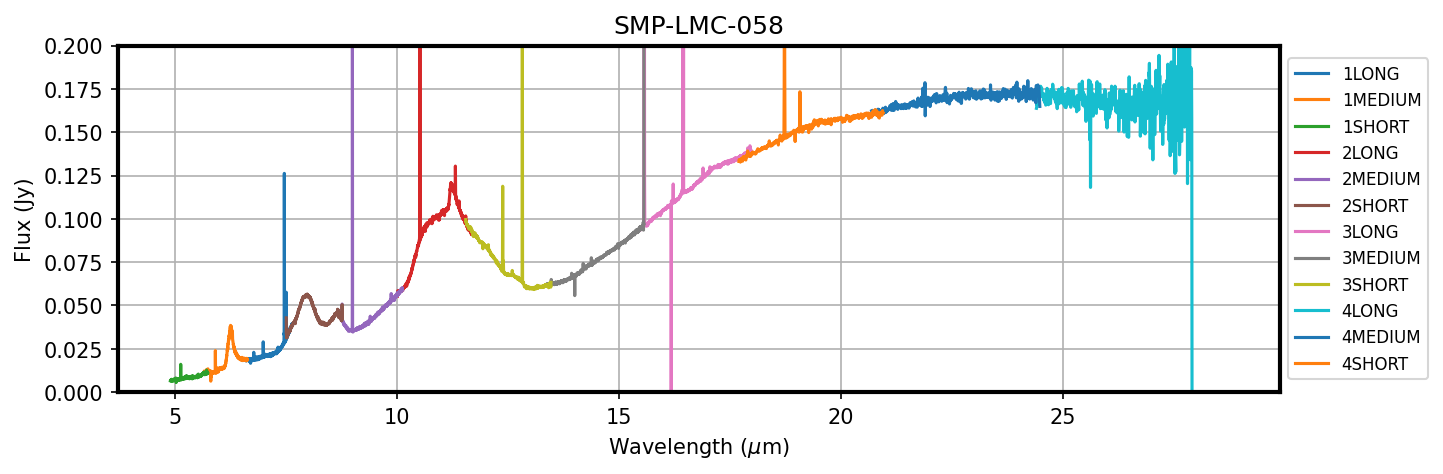

In [28]:
# Normal plots
%matplotlib inline
# Interactive plots
#%matplotlib notebook

rc('axes', linewidth=2)
fig, ax = plt.subplots(1,1, figsize=(10,3), dpi=150)

if (len(x1dfiles) > 0):
    hdu=fits.open(x1dfiles[0])
    objname=hdu[0].header['TARGPROP']
else:
    objname='Unknown'

for file in x1dfiles:
    x1d=fits.open(file)
    x1ddata=x1d[1].data
    wave=x1ddata['WAVELENGTH']
    flux=x1ddata['FLUX']
    
    # labels
    label=x1d[0].header['CHANNEL']+x1d[0].header['BAND']
    
    plt.plot(wave,flux,label=label)
    
plt.xlabel(r'Wavelength ($\mu$m)')
plt.ylabel('Flux (Jy)')
plt.title(objname)
plt.ylim(0,0.2)
plt.legend(fontsize=8, loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()

<hr style="border:1px solid gray"> </hr>

<img style="float: center;" src="https://www.stsci.edu/~dlaw/stsci_logo.png" alt="stsci_logo" width="200px"/> 